# Analysis on the effects of modeling and training decisions for greener computer vision systems

Author: Santiago del Rey

## Import libraries

In [1]:
import os

import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikit_posthocs as sp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
from cliffs_delta import cliffs_delta
from scipy import stats
from statsmodels.formula.api import ols
import pingouin as pg

from environment import FIGURES_DIR, OUTPUT_DIR, DATA_DIR

%matplotlib inline

mlp.rcParams["font.family"] = "serif"
mlp.rcParams["font.serif"] = "Times New Roman"
mlp.rcParams["font.size"] = 8
mlp.rcParams["figure.autolayout"] = "true"

SAVE_FIGS = True

## Load the dataset

In [2]:
analysis_df = pd.read_parquet(
    os.path.join(DATA_DIR, "processed", "dl-training-energy-consumption-dataset.gzip")
)
analysis_df.head()

,training strategy,architecture,run,training duration (h),gpu working time (h),gpu usage,gpu memory working time (h),gpu memory usage,average memory used (MB),memory used std (MB),total power (W),average temperature (Celsius),temperature std (Celsius),energy (GJ),emissions (tCO2e),GFLOPs,accuracy,precision,recall,AUC
0,cloud,mobilenet_v2,0,0.735028,0.168906,0.229977,0.061694,0.084002,23648.752648,24.982796,414928.0,54.269667,1.831817,1.097942,0.070756,0.064028,0.975629,0.959826,0.993169,0.995675
1,cloud,mobilenet_v2,1,0.795914,0.182600,0.229605,0.066108,0.083126,23657.000000,0.000000,439203.0,53.764932,2.649763,1.258444,0.081100,0.064028,0.971108,0.957560,0.986339,0.992465
2,cloud,mobilenet_v2,2,0.471948,0.105261,0.223168,0.038169,0.080925,23657.000000,0.000000,255348.0,53.304476,3.203525,0.433840,0.027959,0.064028,0.960397,0.956488,0.965262,0.987073
3,cloud,mobilenet_v2,3,0.634343,0.144261,0.227581,0.052850,0.083374,23657.000000,0.000000,357267.0,54.024540,3.030651,0.815867,0.052578,0.064028,0.974941,0.962921,0.988290,0.994777
4,cloud,mobilenet_v2,4,0.662703,0.150069,0.226615,0.053986,0.081523,23657.000000,0.000000,356879.0,53.420721,2.745386,0.851418,0.054869,0.064028,0.968553,0.957524,0.981070,0.990629


In [3]:
agg_data = analysis_df.groupby(
    ["training strategy", "architecture"], as_index=False
).agg(
    {
        "training duration (h)": np.mean,
        "gpu usage": np.mean,
        "energy (GJ)": [np.mean, np.std],
        "emissions (tCO2e)": [np.mean],
        "GFLOPs": np.mean,
        "accuracy": [np.mean, np.std],
    }
)

agg_data[("training duration (h)", "mean")] = pd.to_timedelta(
    agg_data[("training duration (h)", "mean")], unit="hours"
)
s = (
    agg_data.style.hide(axis="index")
    .highlight_max(
        subset=[("gpu usage", "mean"), ("accuracy", "mean")],
        props="textbf: --rwrap",
        axis=0,
    )
    .highlight_min(
        subset=[
            ("training duration (h)", "mean"),
            ("energy (GJ)", "mean"),
            ("emissions (tCO2e)", "mean"),
        ],
        props="textbf: --rwrap",
        axis=0,
    )
    .format(
        {("gpu usage", "mean"): lambda x: str(round(x * 100, 3)) + " \%"}, precision=3
    )
)
agg_data

training strategy   architecture     training duration (h) gpu usage  \
                                                        mean      mean   
0             cloud   mobilenet_v2 0 days 00:37:45.371067600  0.226009   
1             cloud  nasnet_mobile    0 days 01:09:49.449600  0.412231   
2             cloud       xception 0 days 00:52:02.951565600  0.595662   
3             local   mobilenet_v2 0 days 02:01:43.916332800  0.944144   
4             local  nasnet_mobile 0 days 08:19:16.989632400  0.962019   
5          local-v2   mobilenet_v2 0 days 00:25:25.597732800  0.561335   

  energy (GJ)           emissions (tCO2e)    GFLOPs  accuracy            
         mean       std              mean      mean      mean       std  
0    0.827987  0.446579          0.053359  0.064028  0.940651  0.068609  
1    3.491154  0.986628          0.224986  0.371647  0.975780  0.001003  
2    2.658450  0.801931          0.171322  2.958404  0.984011  0.001315  
3    1.655734  1.024809          0.106703  0.064028  0.949620  0.058820  
4   25.638382  6.996514          1.652253  0.371647  0.976818  0.001040  
5    0.326644  0.227251          0.021050  0.064028  0.948909  0.067368

## Data analysis

In [4]:
ARCHITECTURES = ["mobilenet_v2", "nasnet_mobile", "xception"]
TRAIN_STRATEGIES = ["cloud", "local"]

analysis_df.rename(
    columns={
        "energy (GJ)": "energy",
        "gpu usage": "gpu_usage",
        "average temperature (Celsius)": "temperature",
        "greenness score": "score",
    },
    inplace=True,
)

In [5]:
def test_normality(x, group=None):
    result = stats.shapiro(x)
    normalized_x = (x - np.mean(x)) / np.std(x)
    if group is None:
        print(f"Shapiro test for normality: W = {result[0]} and p-value {result[1]}")
        _, ax = plt.subplots(1, 1, figsize=(5, 5))
        sm.qqplot(normalized_x, line="45", ax=ax)
        plt.show()
    else:
        print(
            f"Shapiro test for normality of group {group}: W = {result[0]} and p-value {result[1]}"
        )
        _, ax = plt.subplots(1, 1, figsize=(5, 5))
        sm.qqplot(normalized_x, line="45", ax=ax)
        ax.set_title(f"Q-Q plot for group {group}")
        plt.show()
    return result


def test_assumptions(*args):
    if len(args) < 2:
        return test_normality(args)
    args = [np.asarray(arg) for arg in args]
    for i, arg in enumerate(args):
        if arg.ndim != 1:
            raise ValueError("Input samples must be one-dimensional.")
        if arg.size <= 1:
            raise ValueError("Input sample size must be greater than one.")
        if np.isinf(arg).any():
            raise ValueError("Input samples must be finite.")
        test_normality(arg, i)

    result = stats.levene(*args)
    print(f"Levene test for equal variances: W = {result[0]} and p-value = {result[1]}")

In [6]:
def boxplot(
    data,
    x: str = None,
    y: str = None,
    title=None,
    xlabel=None,
    ylabel=None,
    figname=None,
    figsize=(5, 5),
):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.boxplot(data, x=x, y=y, ax=ax)
    ax.yaxis.grid(True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if figname is not None and SAVE_FIGS:
        plt.savefig(os.path.join(FIGURES_DIR, figname))

In [7]:
def barplot(
    data,
    x=None,
    y=None,
    xlabel=None,
    ylabel=None,
    title=None,
    hue=None,
    errorbar=None,
    estimator="mean",
    figname=None,
    figsize=(5, 5),
    barlabel=False,
):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax = sns.barplot(
        data,
        x=x,
        y=y,
        ax=ax,
        hue=hue,
        errorbar=errorbar,
        errwidth=3,
        estimator=estimator,
    )
    ax.yaxis.grid(True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    if barlabel:
        for container in ax.containers:
            ax.bar_label(container, fmt="%.2f")

    if figname is not None and SAVE_FIGS:
        plt.savefig(os.path.join(FIGURES_DIR, figname))
    return fig, ax

#### Test normality and variance homogeneity for the dependent variables
##### Temperature
###### Cloud

In [8]:
cloud_mobilenet = analysis_df.query(
    "`training strategy` == 'cloud' & `architecture` == 'mobilenet_v2'"
)
local_mobilenet = analysis_df.query(
    "`training strategy` == 'local' & `architecture` == 'mobilenet_v2'"
)
cloud_nasnet = analysis_df.query(
    "`training strategy` == 'cloud' & `architecture` == 'nasnet_mobile'"
)
local_nasnet = analysis_df.query(
    "`training strategy` == 'local' & `architecture` == 'nasnet_mobile'"
)
cloud_xception = analysis_df.query(
    "`training strategy` == 'cloud' & `architecture` == 'xception'"
)

Now we test the normality and homogeneity of variance of the temperature in the cloud architecture. The results show that the NASNet measurements of temperature are not normally distributed. Also, the homogeneity of variance is not met.

Shapiro test for normality of group 0: W = 0.9677638411521912 and p-value 0.47994327545166016


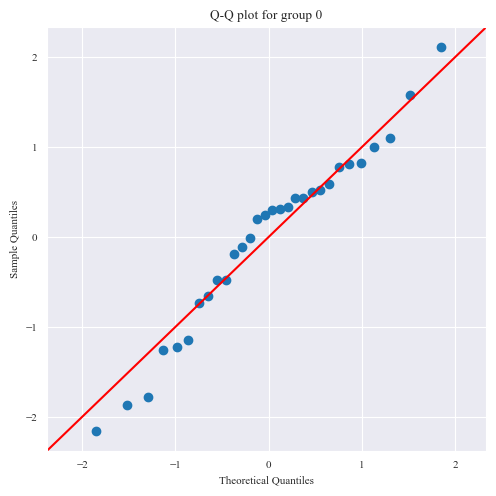

Shapiro test for normality of group 1: W = 0.6851910352706909 and p-value 9.567047527525574e-07


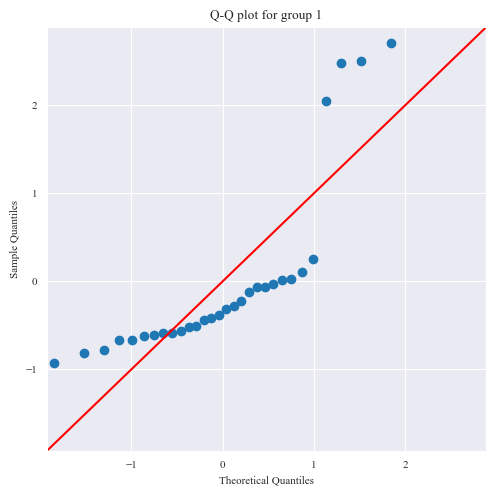

Shapiro test for normality of group 2: W = 0.9667447805404663 and p-value 0.45436176657676697


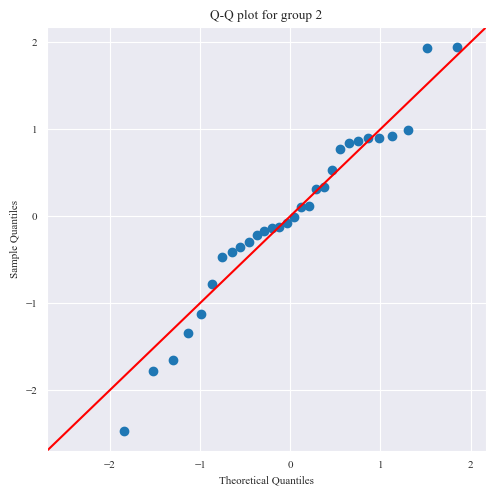

Levene test for equal variances: W = 5.235892974763257 and p-value = 0.0071261393780191916


In [9]:
test_assumptions(
    cloud_mobilenet["temperature"],
    cloud_nasnet["temperature"],
    cloud_xception["temperature"],
)

If we look at the boxplots, we observe that the NASNet architecture has some extreme outliers. Thus, we proceed to remove them.

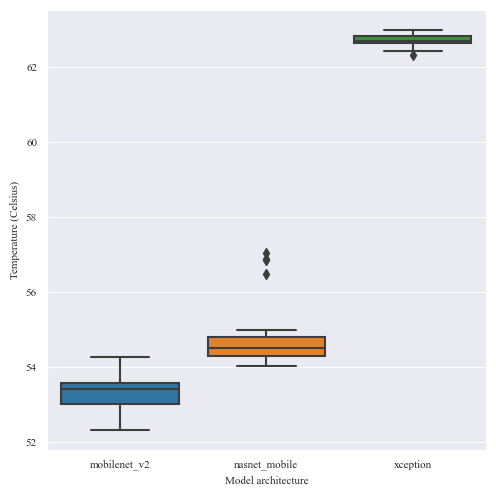

In [10]:
boxplot(
    pd.concat([cloud_mobilenet, cloud_nasnet, cloud_xception]),
    x="architecture",
    y="temperature",
    xlabel="Model architecture",
    ylabel="Temperature (Celsius)",
    figname="cloud-temp-boxplot.eps",
)

Looking at the temperatures from the NASNet architecture we observe that most of the values fall between 54 and 55 Celsius. Seeing this, we decide to remove the four samples that exceed this range.

In [11]:
print(cloud_nasnet["temperature"].describe())
cloud_nasnet["temperature"].sort_values(ascending=False)

count    30.000000
mean     54.791528
std       0.845721
min      54.024550
25%      54.303671
50%      54.505677
75%      54.796893
max      57.039255
Name: temperature, dtype: float64


30    57.039255
31    56.873228
33    56.850823
32    56.491831
34    55.004411
59    54.884863
42    54.811522
36    54.806769
35    54.767263
39    54.742034
40    54.739200
41    54.693352
50    54.606497
37    54.558345
38    54.534595
52    54.476759
49    54.442562
54    54.431542
55    54.372472
44    54.363005
56    54.323257
46    54.306766
51    54.302639
43    54.285155
47    54.276652
48    54.238084
53    54.235114
57    54.145145
58    54.118153
45    54.024550
Name: temperature, dtype: float64

In [12]:
cloud_nasnet_no_temp_outliers = cloud_nasnet.query(f"temperature < 56")
print("Samples removed:", 30 - cloud_nasnet_no_temp_outliers.shape[0])

Samples removed: 4


If we repeat the assumption check without the outliers, we see how the three goups are now normally distributed. However, we still do not met the homogeneity of variance assumption.

Shapiro test for normality of group 0: W = 0.9677638411521912 and p-value 0.47994327545166016


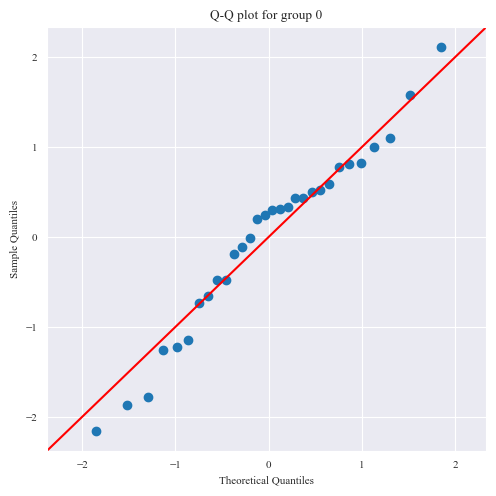

Shapiro test for normality of group 1: W = 0.9641962647438049 and p-value 0.48077625036239624


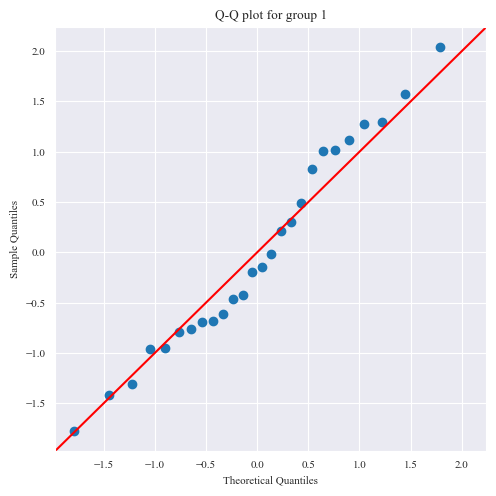

Shapiro test for normality of group 2: W = 0.9667447805404663 and p-value 0.45436176657676697


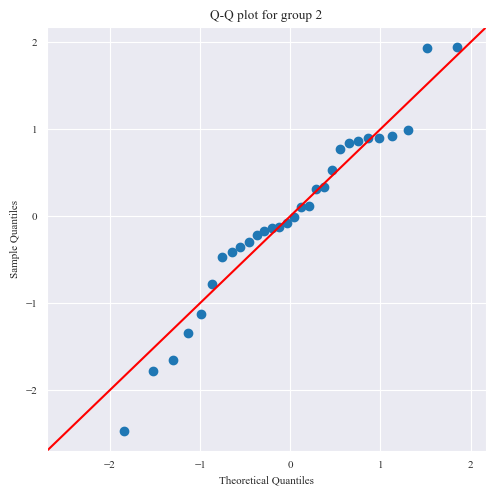

Levene test for equal variances: W = 9.315655445001124 and p-value = 0.00022392286820938897


In [13]:
test_assumptions(
    cloud_mobilenet["temperature"],
    cloud_nasnet_no_temp_outliers["temperature"],
    cloud_xception["temperature"],
)

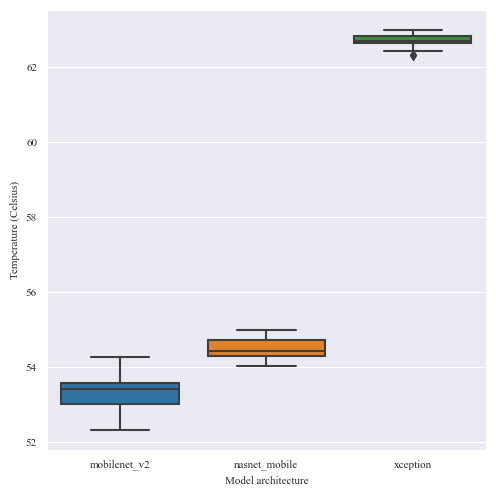

In [14]:
boxplot(
    pd.concat([cloud_mobilenet, cloud_nasnet_no_temp_outliers, cloud_xception]),
    x="architecture",
    y="temperature",
    xlabel="Model architecture",
    ylabel="Temperature (Celsius)",
    figname="cloud-temp-boxplot-noout.eps",
)

###### Local
Now, we check the assumptions for the local training architecture. We observe that the MobileNet V2 architecture does not follow a normal distribution. Also, the homogeneity of variance assumption is met in this case. In this case, we do not observe any outliers in the data.

Shapiro test for normality of group 0: W = 0.9223061800003052 and p-value 0.030794944614171982


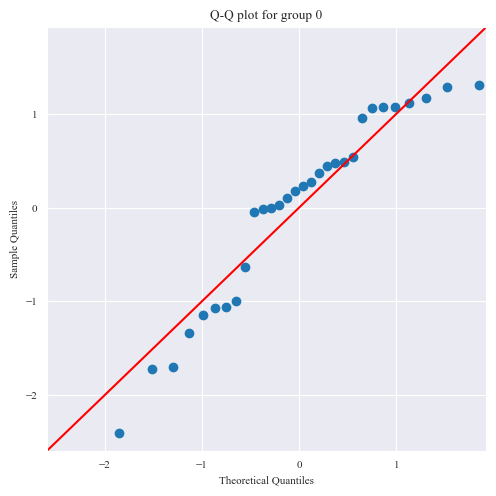

Shapiro test for normality of group 1: W = 0.8860896229743958 and p-value 0.0039021805860102177


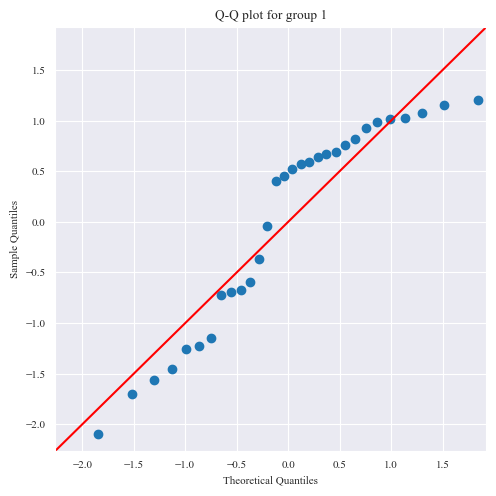

Levene test for equal variances: W = 11.580814759190432 and p-value = 0.0012136726431348727


In [15]:
test_assumptions(local_mobilenet.temperature, local_nasnet.temperature)

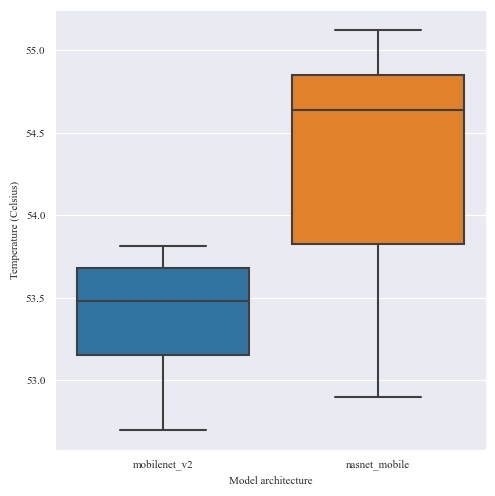

In [16]:
boxplot(
    pd.concat([local_mobilenet, local_nasnet]),
    x="architecture",
    y="temperature",
    xlabel="Model architecture",
    ylabel="Temperature (Celsius)",
    figname="local-temp-boxplot.eps",
)

##### Impact of temperature on energy consumption

In [17]:
temp_vs_energy_df = pd.concat(
    [cloud_mobilenet, cloud_nasnet, cloud_xception, local_mobilenet, local_nasnet]
)

temp_vs_energy_df["combinations"] = (
    temp_vs_energy_df["training strategy"] + " " + temp_vs_energy_df["architecture"]
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


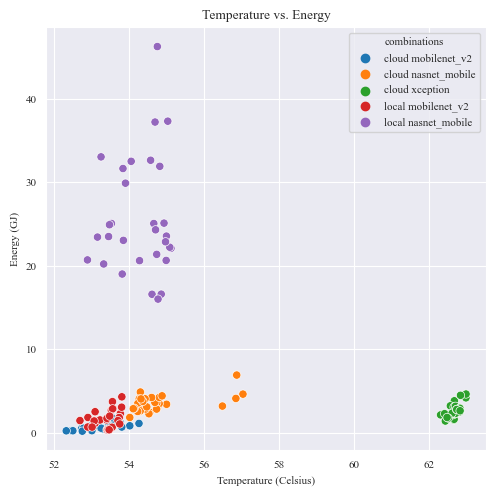

In [18]:
_, axes = plt.subplots(1, 1, figsize=(5, 5))
ax = sns.scatterplot(
    temp_vs_energy_df, x="temperature", y="energy", ax=axes, hue="combinations"
)
ax.set_title("Temperature vs. Energy")
ax.set_xlabel("Temperature (Celsius)")
ax.set_ylabel("Energy (GJ)")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "temperature-energy-scatter.eps"))

Shapiro test for normality of group 0: W = 0.736786961555481 and p-value 2.0954901008840565e-11


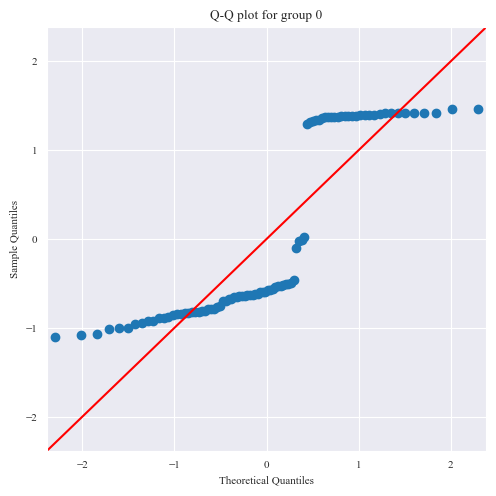

Shapiro test for normality of group 1: W = 0.9647737741470337 and p-value 0.015330162830650806


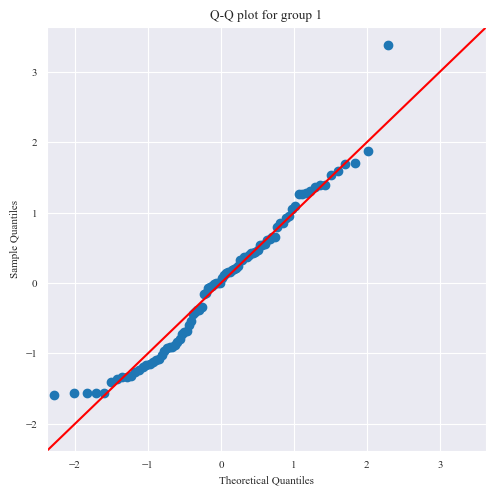

Levene test for equal variances: W = 33.085292384687364 and p-value = 3.775839558621507e-08


In [19]:
cloud_df = temp_vs_energy_df.query("`training strategy` == 'cloud'")
test_assumptions(cloud_df["temperature"], cloud_df["energy"])

Shapiro test for normality of group 0: W = 0.9090379476547241 and p-value 0.00028551919967867434


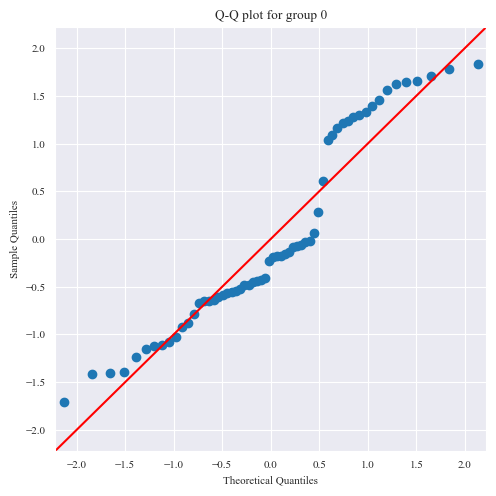

Shapiro test for normality of group 1: W = 0.8400825262069702 and p-value 1.5721900581411319e-06


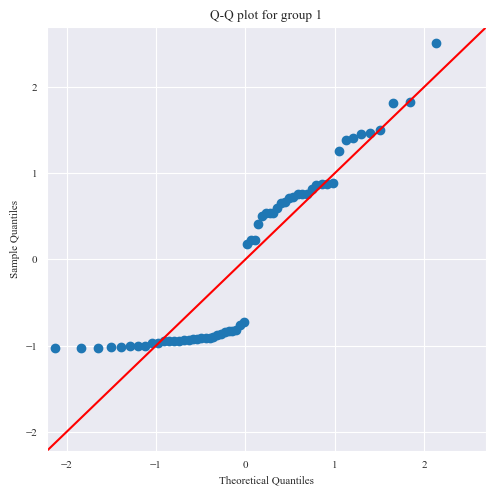

Levene test for equal variances: W = 210.69520626096067 and p-value = 5.127122424531657e-28


In [20]:
local_df = temp_vs_energy_df.query("`training strategy` == 'local'")
test_assumptions(local_df["temperature"], local_df["energy"])

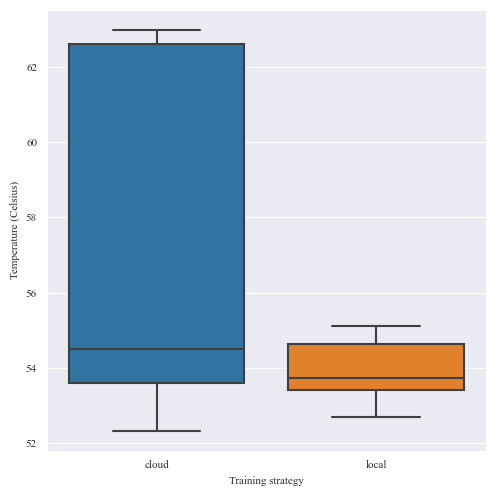

In [21]:
boxplot(
    temp_vs_energy_df,
    x="training strategy",
    y="temperature",
    xlabel="Training strategy",
    ylabel="Temperature (Celsius)",
    figname="temperature-boxplot.eps",
)

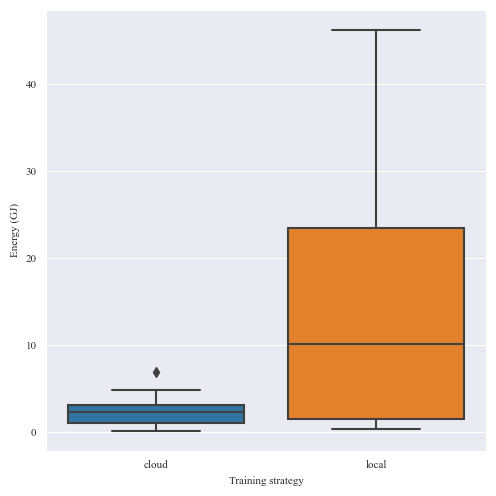

In [22]:
boxplot(
    temp_vs_energy_df,
    x="training strategy",
    y="energy",
    xlabel="Training strategy",
    ylabel="Energy (GJ)",
    figname="energy-boxplot.eps",
)

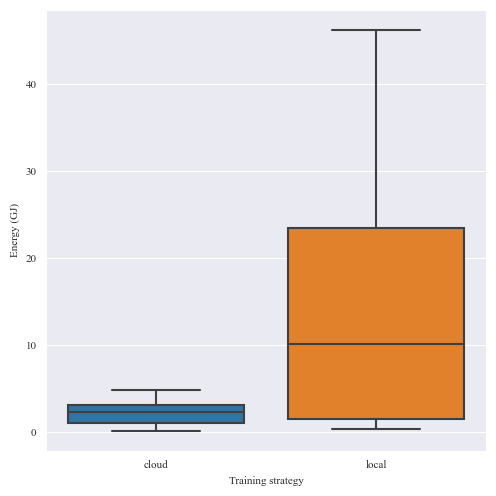

In [23]:
no_outliers_df = pd.concat(
    [cloud_df.sort_values("energy", ascending=True).iloc[:-1], local_df]
)
boxplot(
    no_outliers_df,
    x="training strategy",
    y="energy",
    xlabel="Training strategy",
    ylabel="Energy (GJ)",
)

Shapiro test for normality of group 0: W = 0.7316665053367615 and p-value 1.8557625922066556e-11


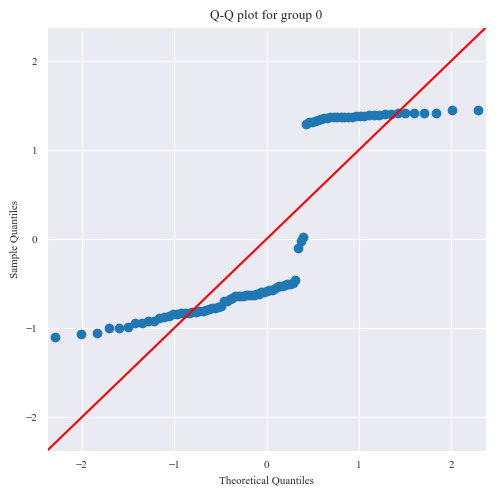

Shapiro test for normality of group 1: W = 0.963354229927063 and p-value 0.012980019673705101


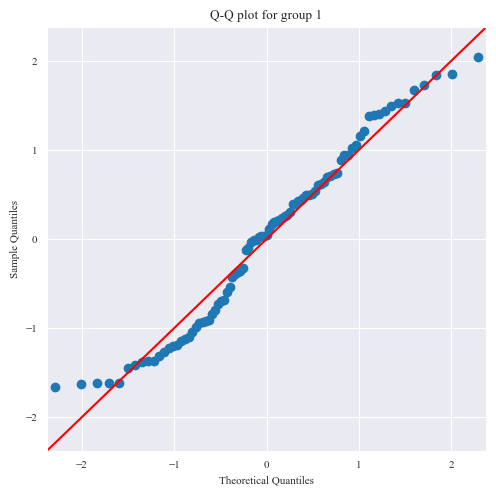

Levene test for equal variances: W = 33.8261578358442 and p-value = 2.7825976389116417e-08


In [24]:
cloud_df = no_outliers_df.query("`training strategy` == 'cloud'")
test_assumptions(cloud_df["temperature"], cloud_df["energy"])

Shapiro test for normality of group 0: W = 0.9090379476547241 and p-value 0.00028551919967867434


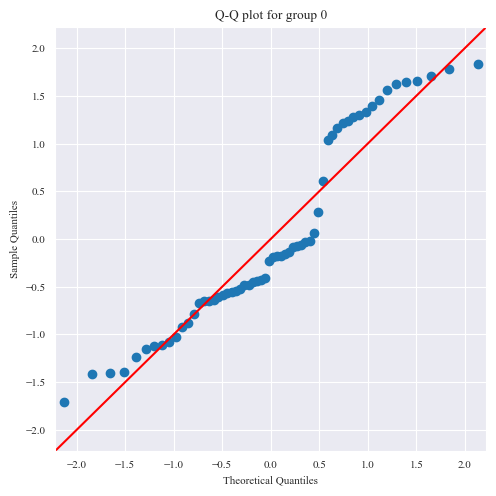

Shapiro test for normality of group 1: W = 0.8400825262069702 and p-value 1.5721900581411319e-06


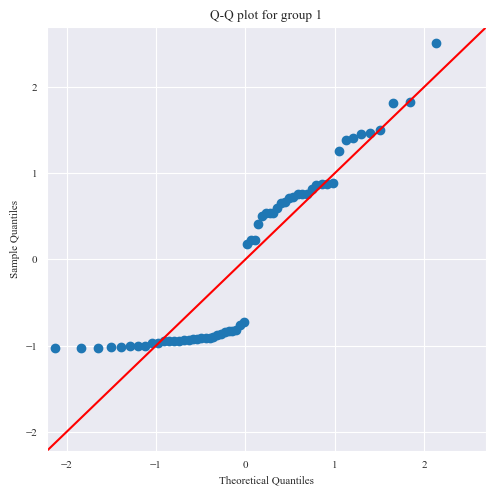

Levene test for equal variances: W = 210.69520626096067 and p-value = 5.127122424531657e-28


In [25]:
local_df = no_outliers_df.query("`training strategy` == 'local'")
test_assumptions(local_df["temperature"], local_df["energy"])

cloud
             temperature    energy
temperature     1.000000  0.650477
energy          0.650477  1.000000
local
             temperature    energy
temperature     1.000000  0.597166
energy          0.597166  1.000000


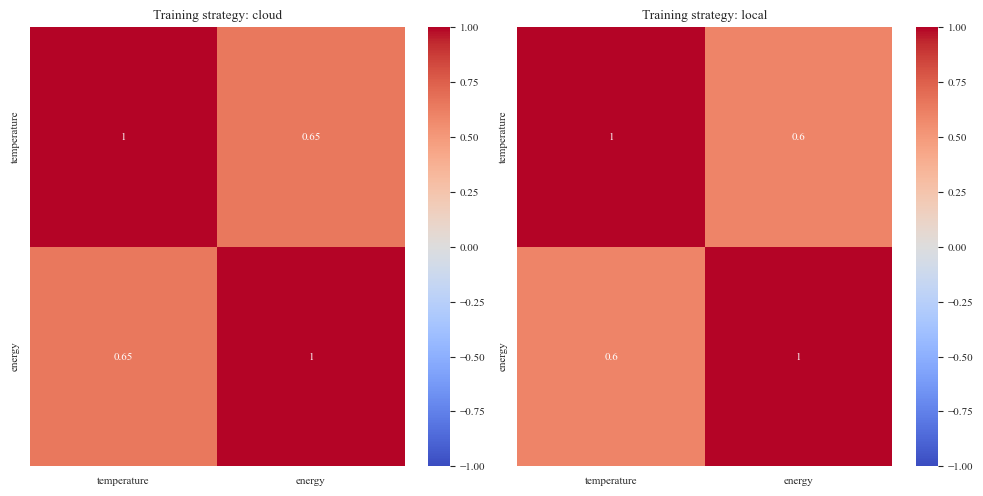

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, strategy in enumerate(TRAIN_STRATEGIES):
    data = no_outliers_df.query("`training strategy` == @strategy")[
        ["temperature", "energy"]
    ]
    corr = data.corr("spearman")
    print(strategy)
    print(corr)
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=axes[i], cmap="coolwarm")
    ax.set_title(f"Training strategy: {strategy}")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "temperature-energy-correlation.eps"))

##### Impact of temperature on GPU usage

In [27]:
temp_vs_gpu_usage_df = pd.concat(
    [cloud_mobilenet, cloud_nasnet, cloud_xception, local_mobilenet, local_nasnet]
)

temp_vs_gpu_usage_df["combinations"] = (
    temp_vs_gpu_usage_df["training strategy"]
    + " "
    + temp_vs_gpu_usage_df["architecture"]
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


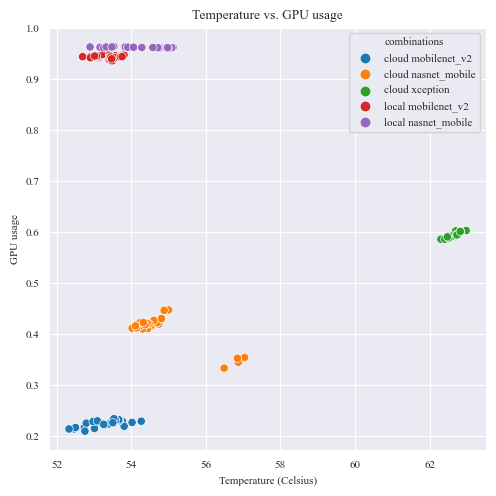

In [28]:
_, axes = plt.subplots(1, 1, figsize=(5, 5))
ax = sns.scatterplot(
    temp_vs_gpu_usage_df, x="temperature", y="gpu_usage", ax=axes, hue="combinations"
)
ax.set_title("Temperature vs. GPU usage")
ax.set_xlabel("Temperature (Celsius)")
ax.set_ylabel("GPU usage")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "temperature-gpu_usage-scatter.eps"))

Shapiro test for normality of group 0: W = 0.736786961555481 and p-value 2.0954901008840565e-11


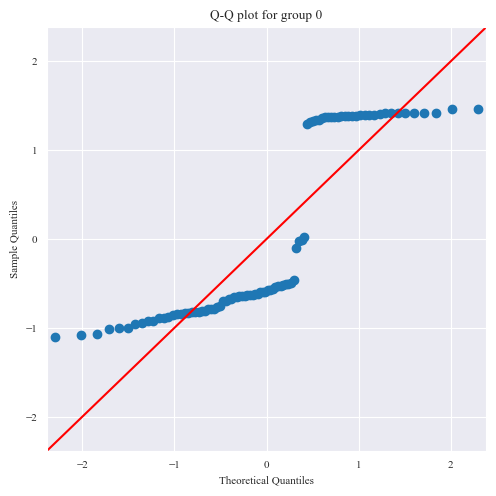

Shapiro test for normality of group 1: W = 0.8270861506462097 and p-value 7.120582790065555e-09


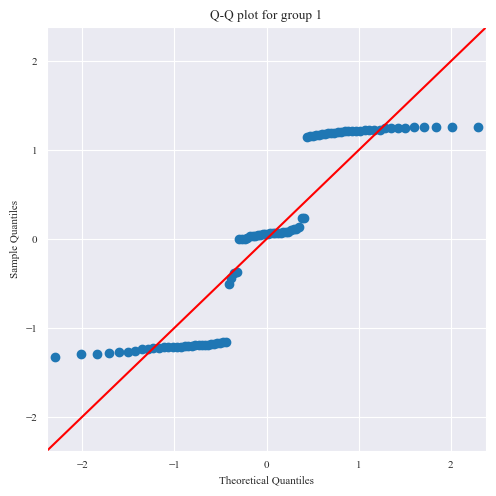

Levene test for equal variances: W = 72.54398034957525 and p-value = 6.702472423762122e-15


In [29]:
cloud_df = temp_vs_gpu_usage_df.query("`training strategy` == 'cloud'")
test_assumptions(cloud_df["temperature"], cloud_df["gpu_usage"])

Shapiro test for normality of group 0: W = 0.9090379476547241 and p-value 0.00028551919967867434


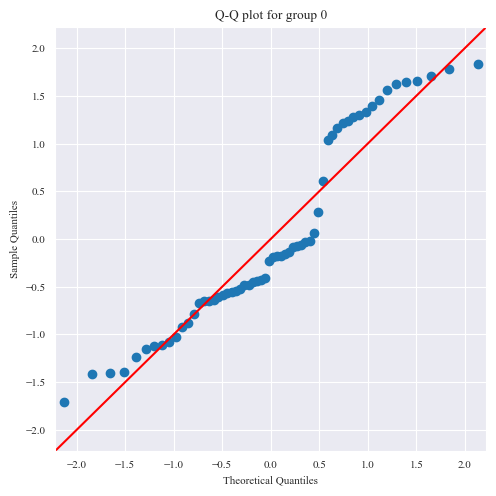

Shapiro test for normality of group 1: W = 0.7974491715431213 and p-value 1.1669445143525081e-07


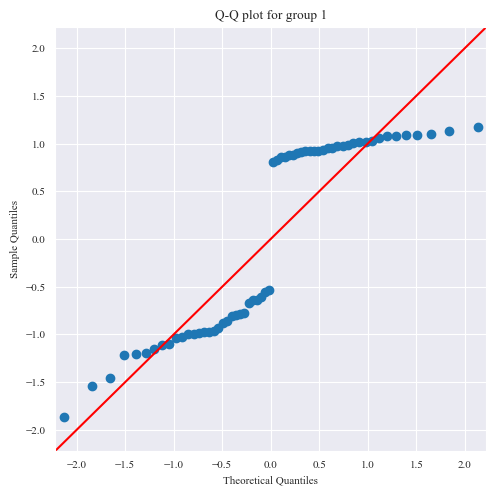

Levene test for equal variances: W = 94.73046541662663 and p-value = 8.618604279193417e-17


In [30]:
local_df = temp_vs_gpu_usage_df.query("`training strategy` == 'local'")
test_assumptions(local_df["temperature"], local_df["gpu_usage"])

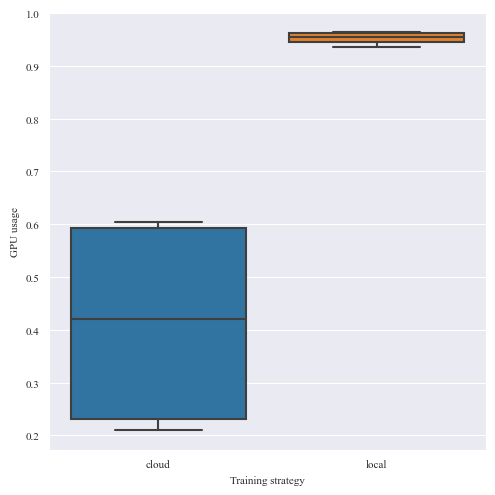

In [31]:
boxplot(
    temp_vs_gpu_usage_df,
    x="training strategy",
    y="gpu_usage",
    xlabel="Training strategy",
    ylabel="GPU usage",
    figname="gpu_usage-boxplot.eps",
)

cloud
             temperature  gpu_usage
temperature     1.000000   0.946808
gpu_usage       0.946808   1.000000
local
             temperature  gpu_usage
temperature     1.000000   0.464851
gpu_usage       0.464851   1.000000


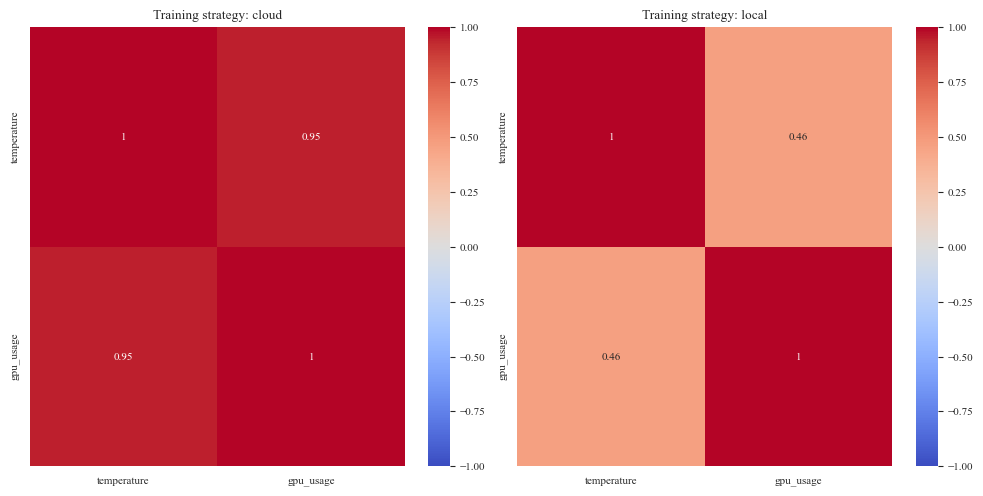

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, strategy in enumerate(TRAIN_STRATEGIES):
    data = temp_vs_gpu_usage_df.query("`training strategy` == @strategy")[
        ["temperature", "gpu_usage"]
    ]
    corr = data.corr("spearman")
    print(strategy)
    print(corr)
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=axes[i], cmap="coolwarm")
    ax.set_title(f"Training strategy: {strategy}")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "temperature-gpu_usage-correlation.eps"))

##### Energy
###### Cloud
We proceed to check if the assumptions are met for the energy measurements.

The results of the tests show that the NASNet is the only one not following a normal distribution. Moreover, we observe that the homogeneity of variance is not met in this case.

Shapiro test for normality of group 0: W = 0.9594272375106812 and p-value 0.2994835376739502


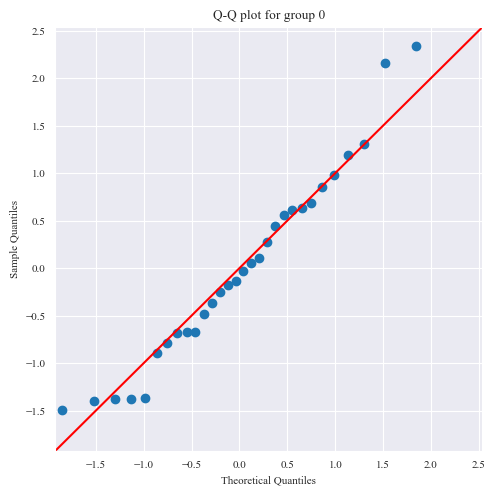

Shapiro test for normality of group 1: W = 0.984474241733551 and p-value 0.9519529938697815


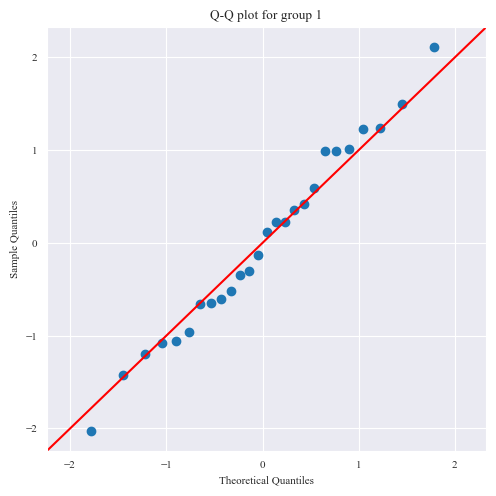

Shapiro test for normality of group 2: W = 0.9307494163513184 and p-value 0.051407475024461746


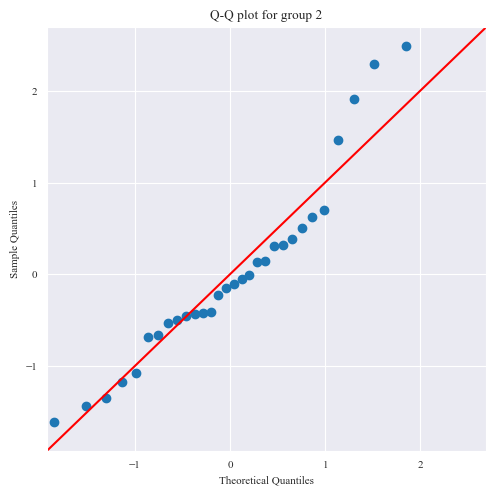

Levene test for equal variances: W = 3.3510287763254536 and p-value = 0.03985116596965773


In [33]:
test_assumptions(
    cloud_mobilenet.energy, cloud_nasnet_no_temp_outliers.energy, cloud_xception.energy
)

As it occurred with the temperature, we observe some extreme outliers. In this case in the NASNet and Xception architectures.

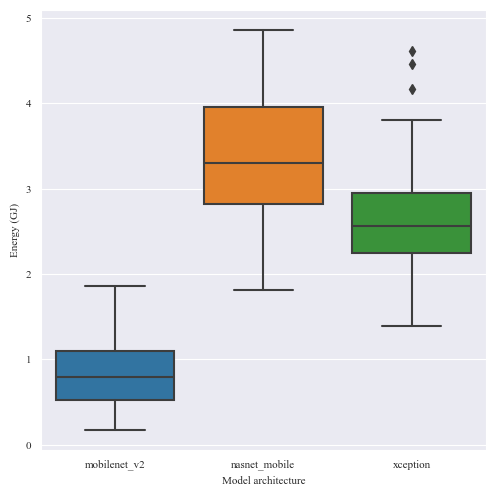

In [34]:
boxplot(
    pd.concat([cloud_mobilenet, cloud_nasnet_no_temp_outliers, cloud_xception]),
    x="architecture",
    y="energy",
    xlabel="Model architecture",
    ylabel="Energy (GJ)",
    figname="cloud-energy-boxplot.eps",
)

We proceed to remove the outliers from the energy measurements.

In [35]:
cloud_xception_no_energy_outliers = cloud_xception.sort_values(by="energy").iloc[:-4]
print("Xception samples removed:", 30 - cloud_xception_no_energy_outliers.shape[0])

Xception samples removed: 4


After removing the outliers, we see how the normality assumption is met for all the architectures. However, we still do not met the homogeneity of variance assumption.

Shapiro test for normality of group 0: W = 0.9594272375106812 and p-value 0.2994835376739502


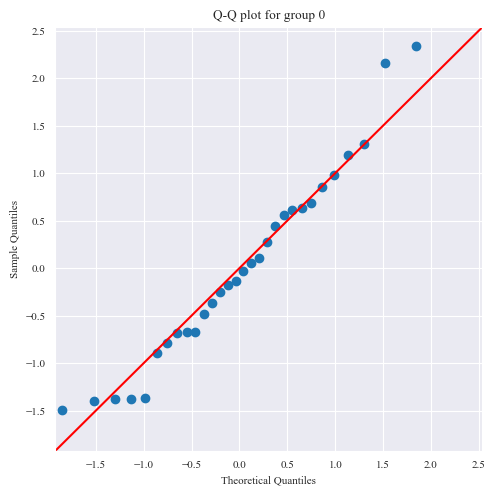

Shapiro test for normality of group 1: W = 0.984474241733551 and p-value 0.9519529938697815


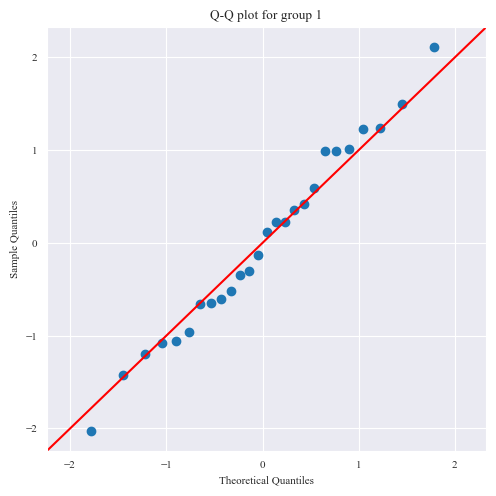

Shapiro test for normality of group 2: W = 0.9620376229286194 and p-value 0.43322208523750305


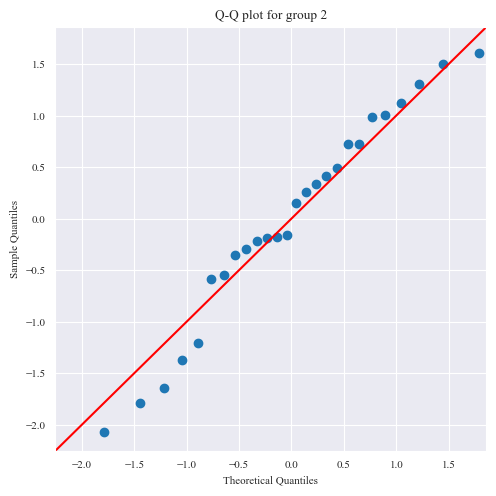

Levene test for equal variances: W = 5.224311687407247 and p-value = 0.007397934675434375


In [36]:
test_assumptions(
    cloud_mobilenet.energy,
    cloud_nasnet_no_temp_outliers.energy,
    cloud_xception_no_energy_outliers.energy,
)

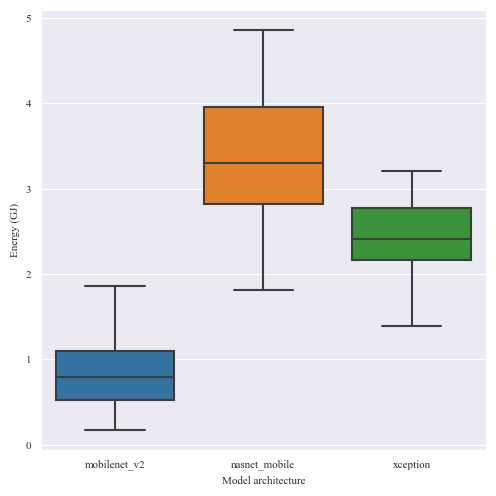

In [37]:
boxplot(
    pd.concat(
        [
            cloud_mobilenet,
            cloud_nasnet_no_temp_outliers,
            cloud_xception_no_energy_outliers,
        ]
    ),
    x="architecture",
    y="energy",
    xlabel="Model architecture",
    ylabel="Energy (GJ)",
    figname="cloud-energy-boxplot-noout.eps",
)

###### Local vs. Cloud
For the Local vs. Cloud analysis of energy, we see that we only meet the normality assumption. Also, looking at the boxplot, we see that there are no outliers.

Shapiro test for normality of group 0: W = 0.9062355160713196 and p-value 0.011973204091191292


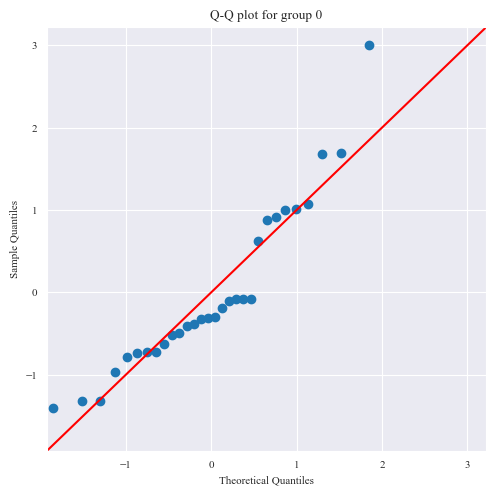

Shapiro test for normality of group 1: W = 0.984474241733551 and p-value 0.9519529938697815


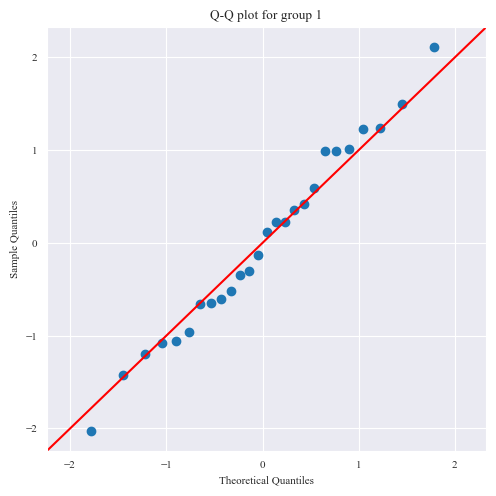

Levene test for equal variances: W = 18.6443528063118 and p-value = 6.77738689921641e-05


In [38]:
test_assumptions(local_nasnet.energy, cloud_nasnet_no_temp_outliers.energy)

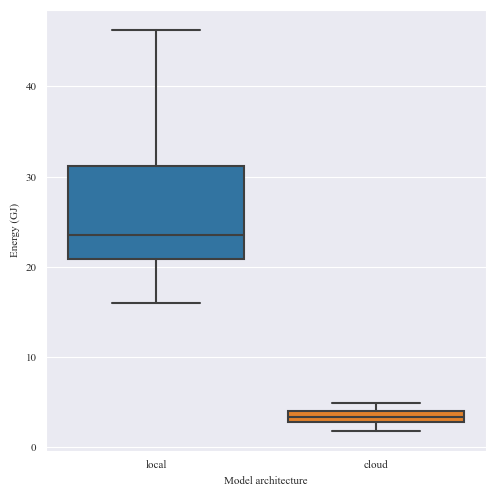

In [39]:
boxplot(
    pd.concat([local_nasnet, cloud_nasnet_no_temp_outliers]),
    x="training strategy",
    y="energy",
    xlabel="Model architecture",
    ylabel="Energy (GJ)",
    figname="local-vs-cloud-energy-boxplot.eps",
)

##### GPU usage
###### Cloud

For the GPU usage we observe that none of the assumptions are met in the cloud training architecture. Also, we observe the presence of outliers in the NASNet measurements.

Shapiro test for normality of group 0: W = 0.9210043549537659 and p-value 0.02848147787153721


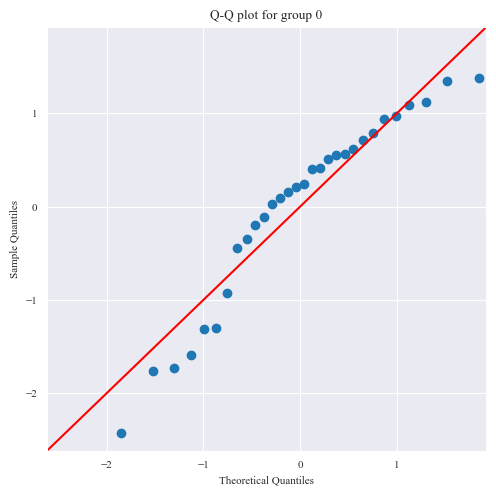

Shapiro test for normality of group 1: W = 0.8396122455596924 and p-value 0.0009005087777040899


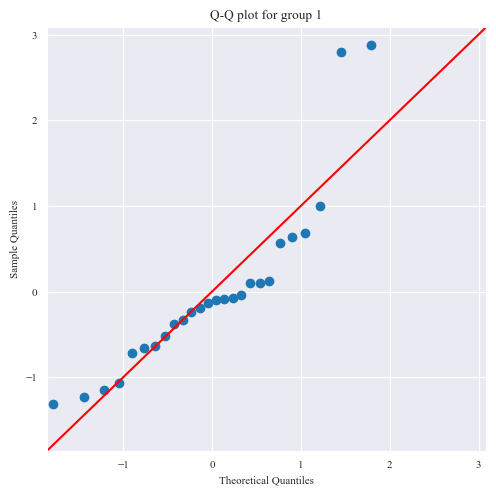

Shapiro test for normality of group 2: W = 0.950732409954071 and p-value 0.17686618864536285


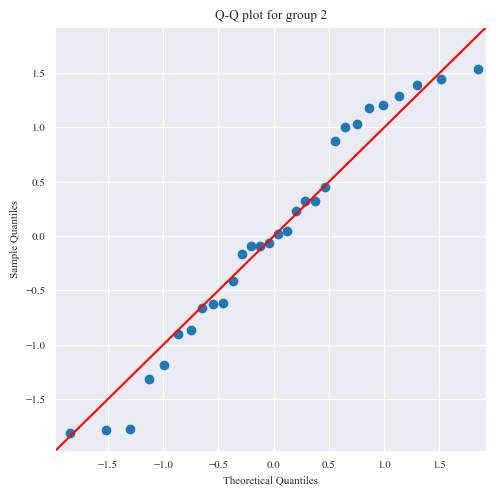

Levene test for equal variances: W = 0.7779951048144733 and p-value = 0.46264627738629693


In [40]:
test_assumptions(
    cloud_mobilenet.gpu_usage,
    cloud_nasnet_no_temp_outliers.gpu_usage,
    cloud_xception.gpu_usage,
)

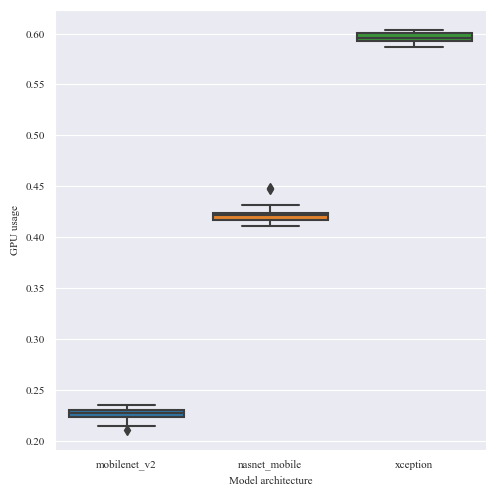

In [41]:
boxplot(
    pd.concat([cloud_mobilenet, cloud_nasnet_no_temp_outliers, cloud_xception]),
    x="architecture",
    y="gpu_usage",
    xlabel="Model architecture",
    ylabel="GPU usage",
    figname="cloud-gpu_usage-boxplot.eps",
)

In [42]:
cloud_nasnet_no_gpu_outliers = cloud_nasnet_no_temp_outliers.sort_values(
    by="gpu_usage", ascending=True
).iloc[:-2]
print("NASNet samples removed:", 30 - cloud_nasnet_no_gpu_outliers.shape[0])
cloud_mobilenet_no_gpu_outliers = cloud_mobilenet.sort_values(
    by="gpu_usage", ascending=True
).iloc[1:]
print("MobileNet samples removed:", 30 - cloud_mobilenet_no_gpu_outliers.shape[0])

NASNet samples removed: 6
MobileNet samples removed: 1


Shapiro test for normality of group 0: W = 0.9194395542144775 and p-value 0.029511749744415283


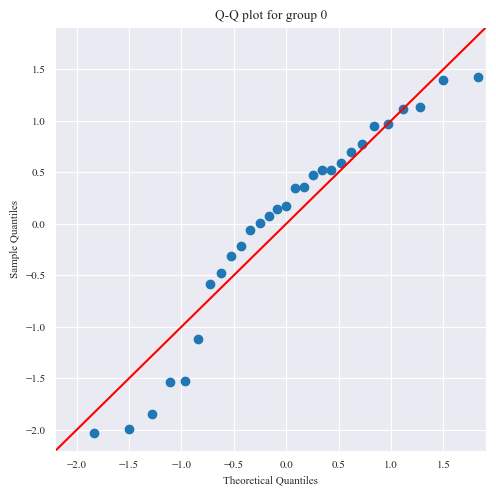

Shapiro test for normality of group 1: W = 0.968847930431366 and p-value 0.6386191248893738


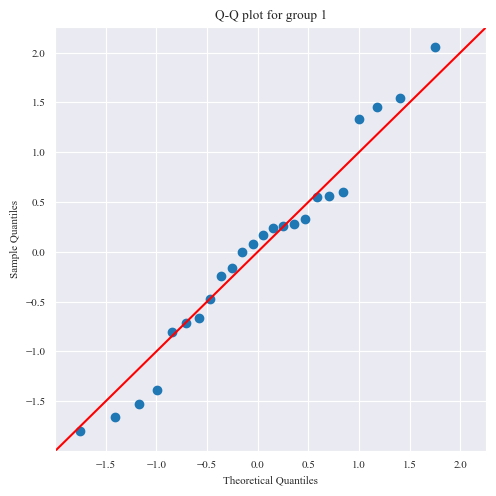

Shapiro test for normality of group 2: W = 0.950732409954071 and p-value 0.17686618864536285


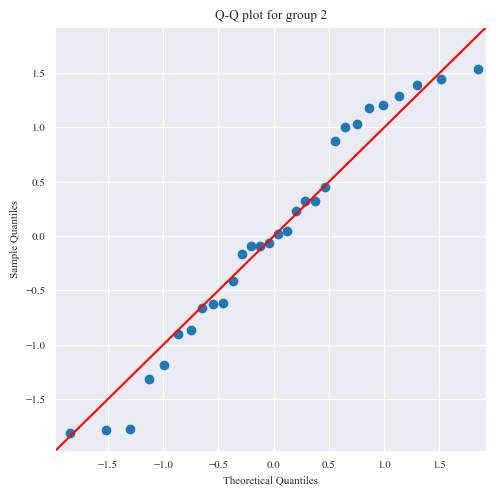

Levene test for equal variances: W = 0.12905213621582592 and p-value = 0.8791107425742737


In [43]:
test_assumptions(
    cloud_mobilenet_no_gpu_outliers.gpu_usage,
    cloud_nasnet_no_gpu_outliers.gpu_usage,
    cloud_xception.gpu_usage,
)

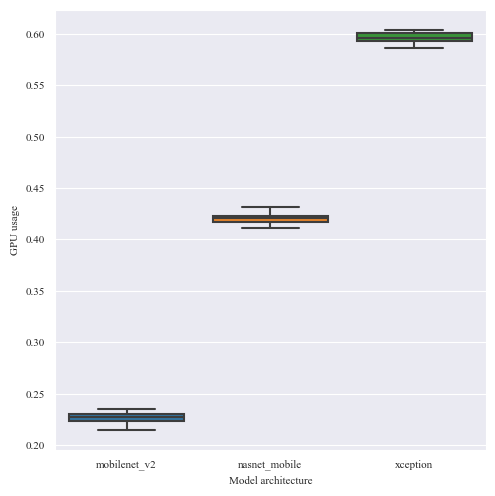

In [44]:
boxplot(
    pd.concat(
        [cloud_mobilenet_no_gpu_outliers, cloud_nasnet_no_gpu_outliers, cloud_xception]
    ),
    x="architecture",
    y="gpu_usage",
    xlabel="Model architecture",
    ylabel="GPU usage",
)

###### Local vs. Cloud

The results on the local architecture show that we met the normality assumptions but not the equality of variances.

Shapiro test for normality of group 0: W = 0.9723883271217346 and p-value 0.6063771843910217


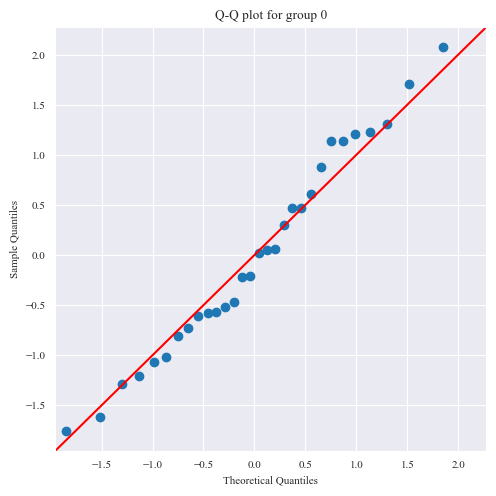

Shapiro test for normality of group 1: W = 0.968847930431366 and p-value 0.6386191248893738


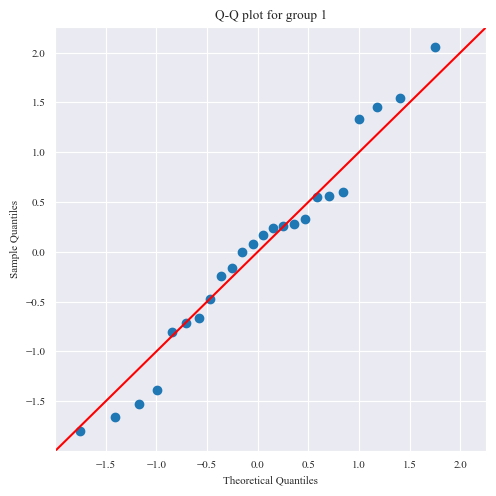

Levene test for equal variances: W = 28.789825332791743 and p-value = 1.893268284767081e-06


In [45]:
test_assumptions(local_nasnet.gpu_usage, cloud_nasnet_no_gpu_outliers.gpu_usage)

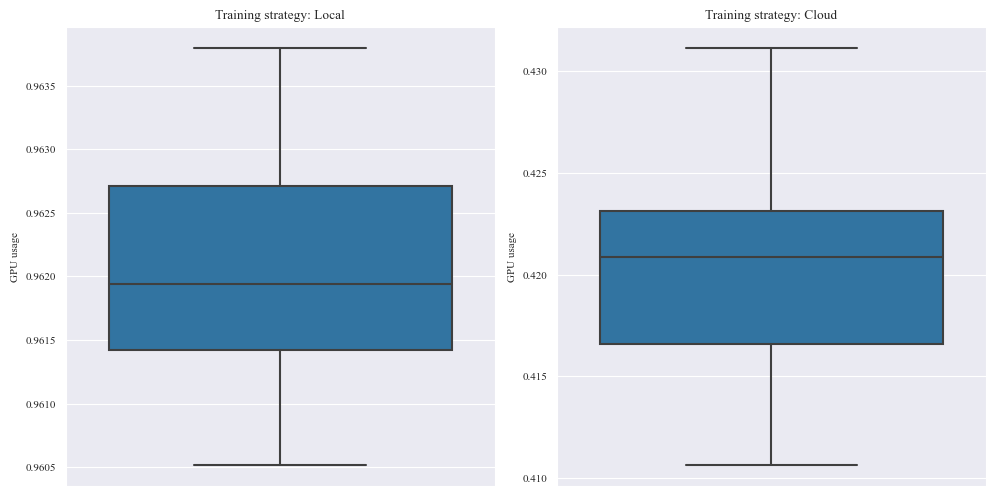

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(y=local_nasnet.gpu_usage, ax=ax1)
ax1.set_ylabel("GPU usage")
ax1.set_title("Training strategy: Local")

sns.boxplot(y=cloud_nasnet_no_gpu_outliers.gpu_usage, ax=ax2)
ax2.set_ylabel("GPU usage")
ax2.set_title("Training strategy: Cloud")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "cloud-local-gpu_usage-boxplot.eps"))

##### Accuracy
###### Cloud
When we check the assumptions for the binary accuracy, we see that MobileNet V2 does not follow a normal distribution. Also, we reject the null hypothesis of equal variances.

Shapiro test for normality of group 0: W = 0.572966456413269 and p-value 3.468401033046575e-08


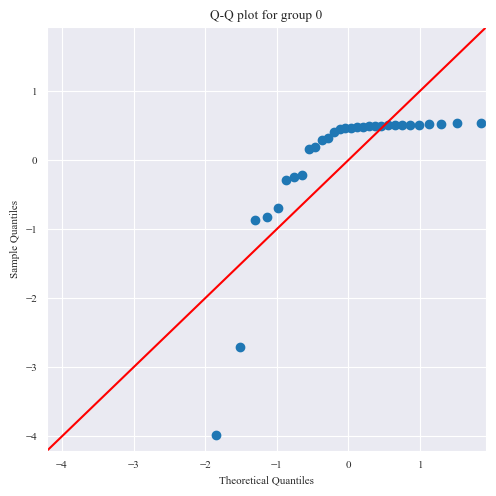

Shapiro test for normality of group 1: W = 0.9551926851272583 and p-value 0.23234178125858307


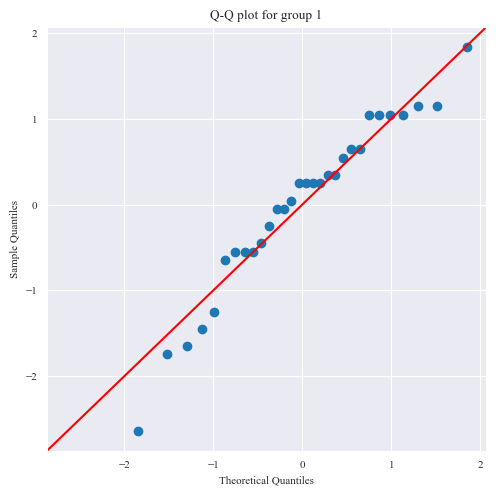

Shapiro test for normality of group 2: W = 0.9617428183555603 and p-value 0.3429679870605469


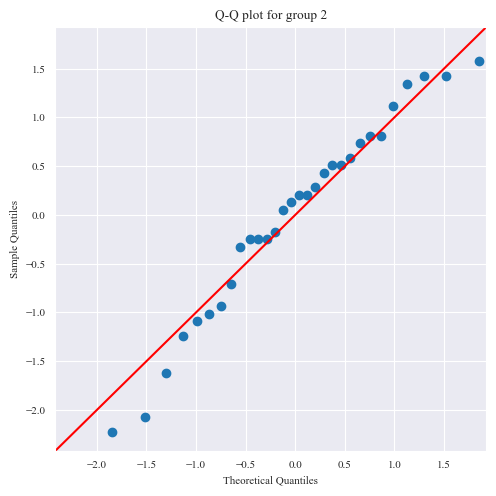

Levene test for equal variances: W = 7.223068943316284 and p-value = 0.0012526866895026664


In [47]:
test_assumptions(
    cloud_mobilenet.accuracy, cloud_nasnet.accuracy, cloud_xception.accuracy
)

Looking at the boxplot, we see that the MobileNet V2 architecture has some extreme outliers. Thus, we proceed to remove them.

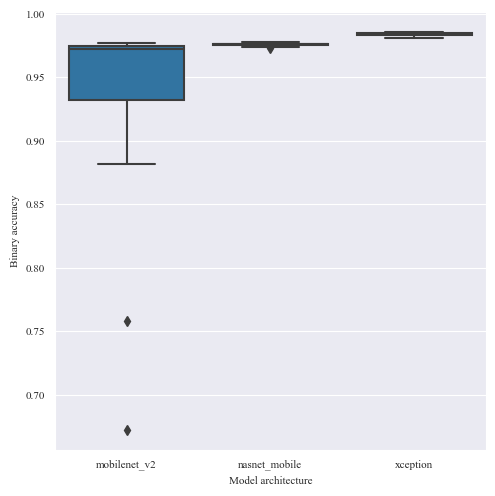

In [48]:
boxplot(
    pd.concat([cloud_mobilenet, cloud_nasnet, cloud_xception]),
    x="architecture",
    y="accuracy",
    xlabel="Model architecture",
    ylabel="Binary accuracy",
    figname="cloud-accuracy-boxplot.eps",
)

In [49]:
mean_acc = cloud_mobilenet["accuracy"].mean()
std_acc = cloud_mobilenet["accuracy"].std()
n_std = 1

cloud_mobilenet_no_accuracy_outliers = cloud_mobilenet[
    (mean_acc - (n_std * std_acc) <= cloud_mobilenet["accuracy"])
    & (cloud_mobilenet["accuracy"] <= mean_acc + (n_std * std_acc))
]
print("MobileNet samples removed:", 30 - cloud_mobilenet_no_accuracy_outliers.shape[0])
cloud_nasnet_no_accuracy_outliers = cloud_nasnet.sort_values(
    "accuracy", ascending=True
).iloc[1:]
print("NASNet samples removed:", 30 - cloud_nasnet_no_accuracy_outliers.shape[0])

MobileNet samples removed: 2
NASNet samples removed: 1


Shapiro test for normality of group 0: W = 0.6853504776954651 and p-value 1.7808552001952194e-06


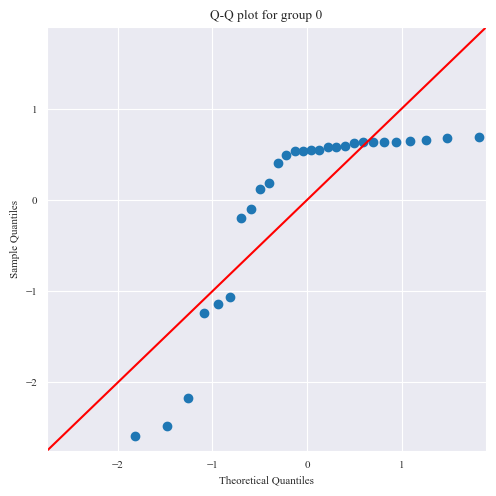

Shapiro test for normality of group 1: W = 0.9613905549049377 and p-value 0.35554441809654236


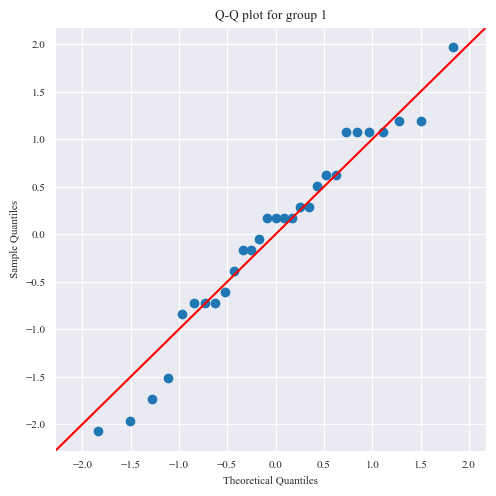

Shapiro test for normality of group 2: W = 0.9617428183555603 and p-value 0.3429679870605469


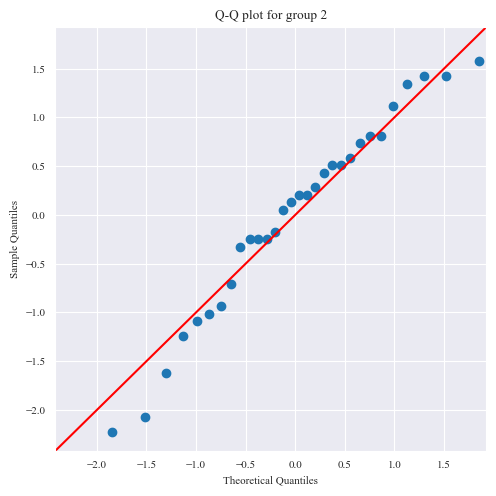

Levene test for equal variances: W = 10.938591751738945 and p-value = 5.998325921960416e-05


In [50]:
test_assumptions(
    cloud_mobilenet_no_accuracy_outliers.accuracy,
    cloud_nasnet_no_accuracy_outliers.accuracy,
    cloud_xception.accuracy,
)

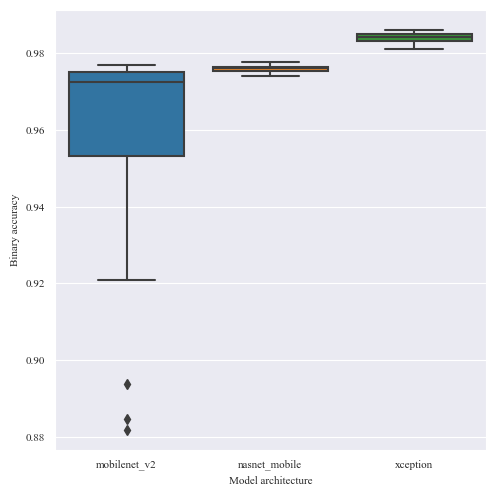

In [51]:
boxplot(
    pd.concat(
        [
            cloud_mobilenet_no_accuracy_outliers,
            cloud_nasnet_no_accuracy_outliers,
            cloud_xception,
        ]
    ),
    x="architecture",
    y="accuracy",
    xlabel="Model architecture",
    ylabel="Binary accuracy",
)

### Comparison between model architectures

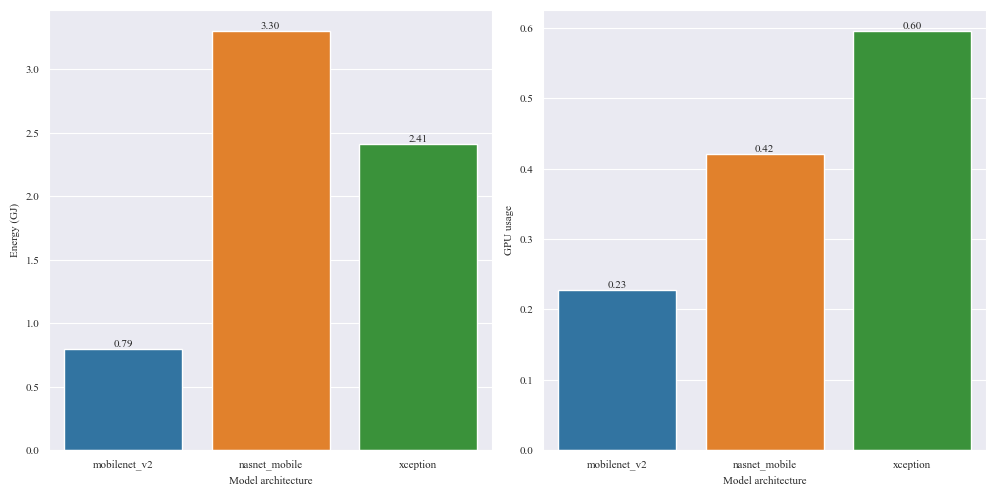

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
cloud_energy = pd.concat(
    [cloud_mobilenet, cloud_nasnet_no_temp_outliers, cloud_xception_no_energy_outliers]
)
ax = sns.barplot(
    cloud_energy,
    x="architecture",
    y="energy",
    errorbar=None,
    estimator="median",
    ax=ax1,
)
ax.yaxis.grid(True)
ax.set_xlabel("Model architecture")
ax.set_ylabel("Energy (GJ)")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")

cloud_gpu = pd.concat(
    [cloud_mobilenet_no_gpu_outliers, cloud_nasnet_no_gpu_outliers, cloud_xception]
)
ax = sns.barplot(
    cloud_gpu,
    x="architecture",
    y="gpu_usage",
    errorbar=None,
    estimator="median",
    ax=ax2,
)
ax.yaxis.grid(True)
ax.set_xlabel("Model architecture")
ax.set_ylabel("GPU usage")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "cloud-energy-gpu-comparison.eps"))

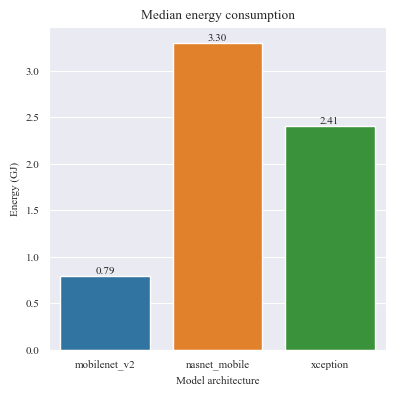

In [53]:
_, ax = barplot(
    cloud_energy,
    x="architecture",
    y="energy",
    estimator="median",
    xlabel="Model architecture",
    ylabel="Energy (GJ)",
    title="Median energy consumption",
    barlabel=True,
    figsize=(4, 4),
    figname="cloud-energy-comparison.eps",
)

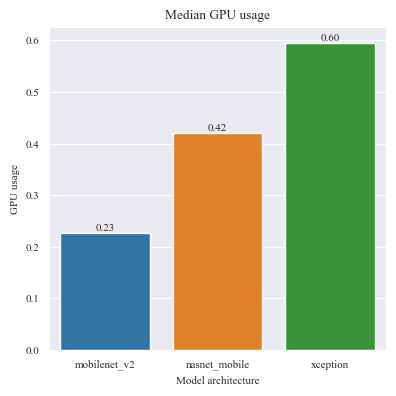

In [54]:
_, ax = barplot(
    cloud_gpu,
    x="architecture",
    y="gpu_usage",
    estimator="median",
    xlabel="Model architecture",
    ylabel="GPU usage",
    title="Median GPU usage",
    barlabel=True,
    figsize=(4, 4),
    figname="cloud-gpu-comparison.eps",
)

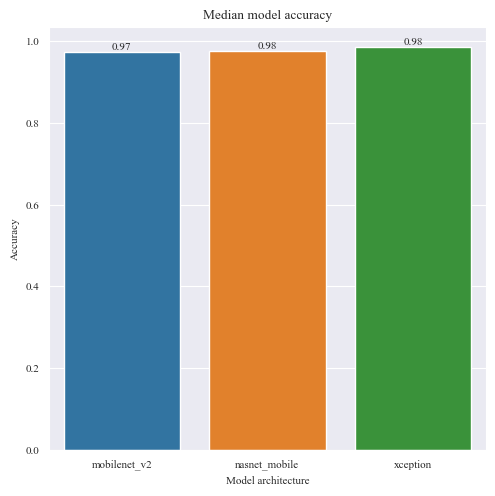

In [55]:
cloud_accuracy = pd.concat(
    [
        cloud_mobilenet_no_accuracy_outliers,
        cloud_nasnet_no_accuracy_outliers,
        cloud_xception,
    ]
)
_, ax = barplot(
    cloud_accuracy,
    x="architecture",
    y="accuracy",
    xlabel="Model architecture",
    ylabel="Accuracy",
    title="Median model accuracy",
    estimator="median",
    barlabel=True,
    figname="cloud-accuracy-comparison.eps",
)

### Comparison between training strategies

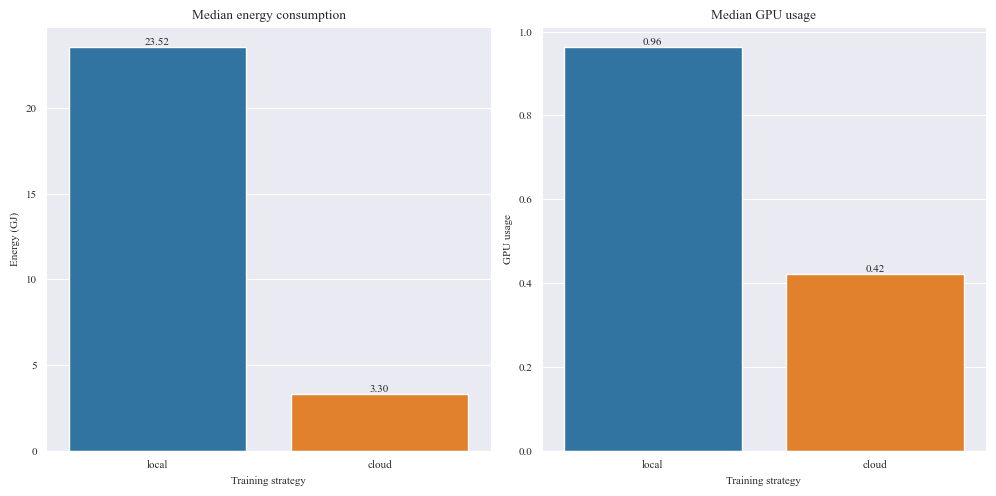

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
local_cloud_energy = pd.concat([local_nasnet, cloud_nasnet_no_temp_outliers])
ax = sns.barplot(
    local_cloud_energy,
    x="training strategy",
    y="energy",
    errorbar=None,
    estimator="median",
    ax=ax1,
)
ax.yaxis.grid(True)
ax.set_title("Median energy consumption")
ax.set_xlabel("Training strategy")
ax.set_ylabel("Energy (GJ)")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")

local_cloud_gpu = pd.concat([local_nasnet, cloud_nasnet_no_gpu_outliers])
ax = sns.barplot(
    local_cloud_gpu,
    x="training strategy",
    y="gpu_usage",
    errorbar=None,
    estimator="median",
    ax=ax2,
)
ax.yaxis.grid(True)
ax.set_title("Median GPU usage")
ax.set_xlabel("Training strategy")
ax.set_ylabel("GPU usage")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "local-cloud-energy-gpu-comparison.eps"))

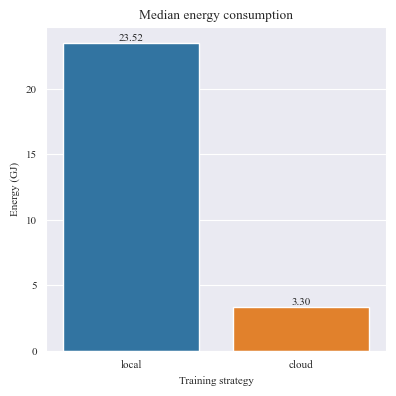

In [57]:
_, ax = barplot(
    local_cloud_energy,
    x="training strategy",
    y="energy",
    estimator="median",
    xlabel="Training strategy",
    ylabel="Energy (GJ)",
    title="Median energy consumption",
    barlabel=True,
    figsize=(4, 4),
    figname="local-cloud-energy-comparison.eps",
)

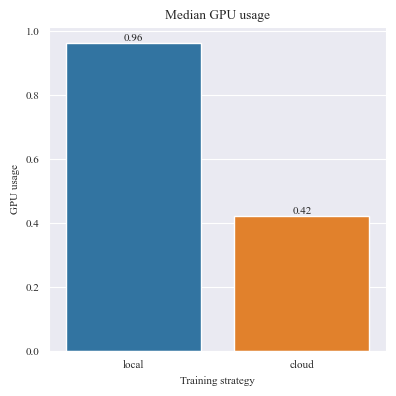

In [58]:
_, ax = barplot(
    local_cloud_gpu,
    x="training strategy",
    y="gpu_usage",
    estimator="median",
    xlabel="Training strategy",
    ylabel="GPU usage",
    title="Median GPU usage",
    barlabel=True,
    figsize=(4, 4),
    figname="local-cloud-gpu-comparison.eps",
)

### FLOPs vs. Energy and GPU usage

In [59]:
flops_vs_energy_df = pd.concat(
    [
        cloud_mobilenet_no_gpu_outliers,
        cloud_nasnet_no_temp_outliers,
        cloud_xception_no_energy_outliers,
        local_mobilenet,
        local_nasnet,
    ]
)

flops_vs_energy_df["combinations"] = (
    flops_vs_energy_df["training strategy"] + " " + flops_vs_energy_df["architecture"]
)

C:\Users\santi\AppData\Local\Temp\ipykernel_12188\3411665670.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cloud.loc[:, "GFLOPs"] = cloud["GFLOPs"].round(3)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


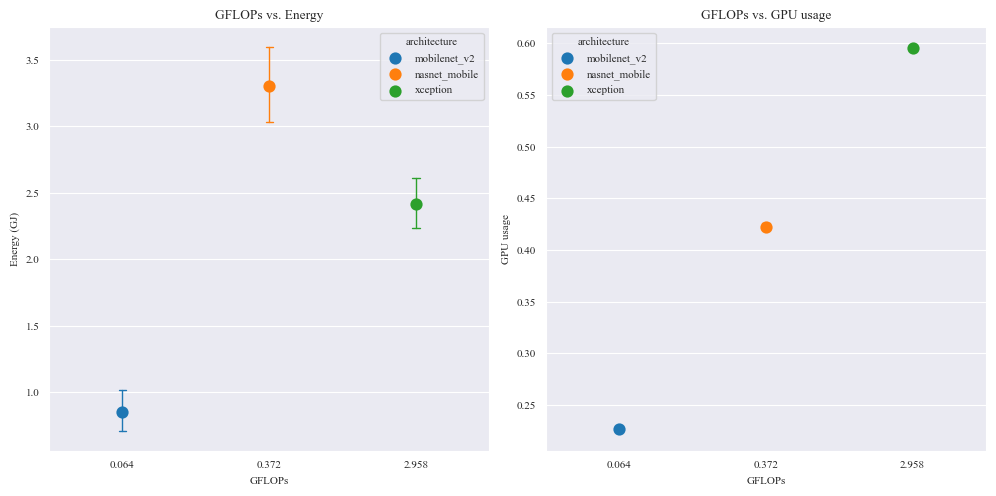

In [60]:
_, axes = plt.subplots(1, 2, figsize=(10, 5))
cloud = flops_vs_energy_df.query("`training strategy` == 'cloud'")
cloud.loc[:, "GFLOPs"] = cloud["GFLOPs"].round(3)
ax = sns.pointplot(
    cloud,
    x="GFLOPs",
    y="energy",
    ax=axes[0],
    hue="architecture",
    errorbar=("ci", 95),
    errwidth=1,
    capsize=0.05,
)
ax.set_title("GFLOPs vs. Energy")
ax.set_xlabel("GFLOPs")
ax.set_ylabel("Energy (GJ)")

ax = sns.pointplot(
    cloud,
    x="GFLOPs",
    y="gpu_usage",
    ax=axes[1],
    hue="architecture",
    errorbar=("ci", 95),
    errwidth=1,
    capsize=0.05,
)
ax.set_title("GFLOPs vs. GPU usage")
ax.set_xlabel("GFLOPs")
ax.set_ylabel("GPU usage")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "flops-vs-energy-and-gpu-usage.eps"))

Shapiro test for normality of group 0: W = 0.6515548229217529 and p-value 1.444042151479974e-12


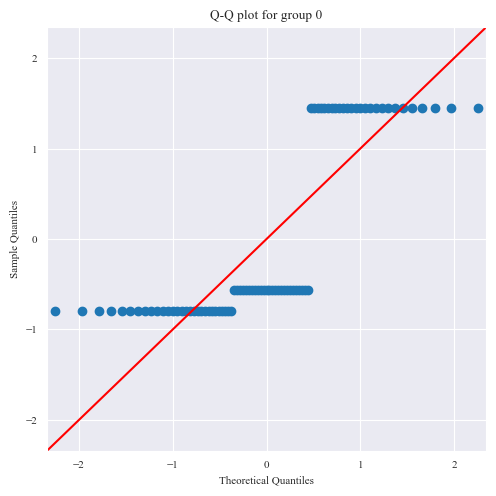

Shapiro test for normality of group 1: W = 0.9665275812149048 and p-value 0.03242601454257965


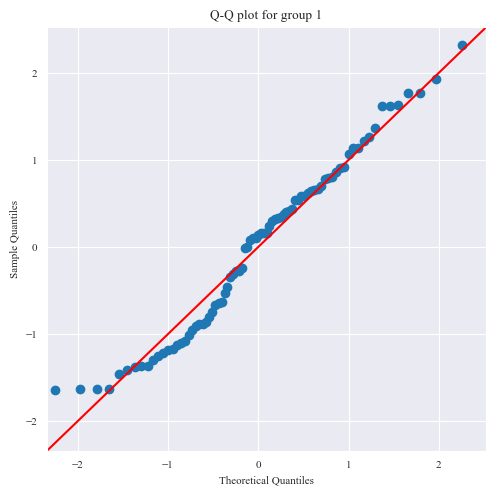

Levene test for equal variances: W = 0.09849115428876501 and p-value = 0.7540566655017703


In [61]:
cloud_df = flops_vs_energy_df.query("`training strategy` == 'cloud'")
test_assumptions(cloud_df["GFLOPs"], cloud_df["energy"])

Shapiro test for normality of group 0: W = 0.636616051197052 and p-value 6.364791332869046e-11


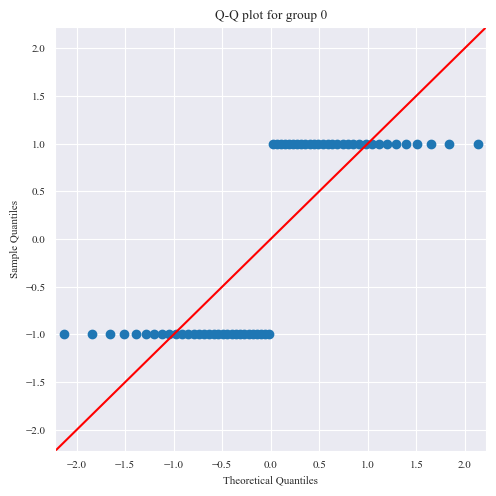

Shapiro test for normality of group 1: W = 0.8400825262069702 and p-value 1.5721900581411319e-06


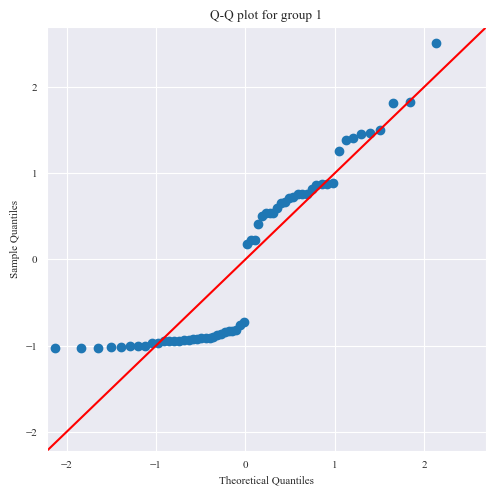

Levene test for equal variances: W = 226.78131680140592 and p-value = 3.0209419868648875e-29


In [62]:
local_df = flops_vs_energy_df.query("`training strategy` == 'local'")
test_assumptions(local_df["GFLOPs"], local_df["energy"])

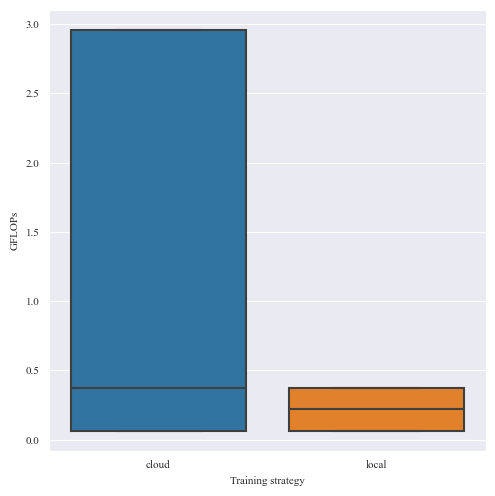

In [63]:
boxplot(
    flops_vs_energy_df,
    x="training strategy",
    y="GFLOPs",
    xlabel="Training strategy",
    ylabel="GFLOPs",
    figname="flops-boxplot.eps",
)

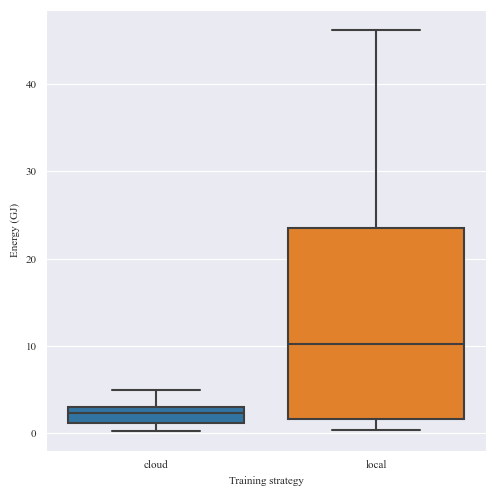

In [64]:
boxplot(
    flops_vs_energy_df,
    x="training strategy",
    y="energy",
    xlabel="Training strategy",
    ylabel="Energy (GJ)",
    figname="energy-boxplot.eps",
)

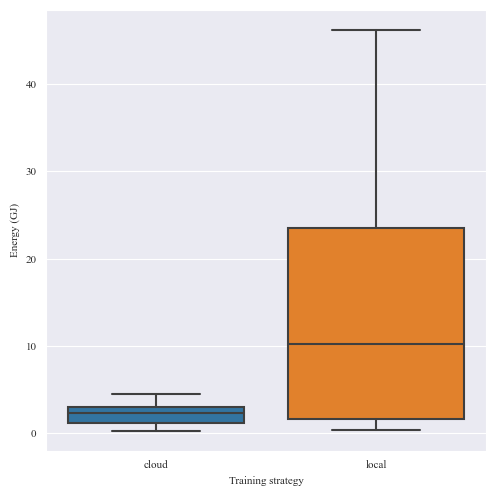

In [65]:
no_outliers_df = pd.concat(
    [cloud_df.sort_values("energy", ascending=True).iloc[:-1], local_df]
)
boxplot(
    no_outliers_df,
    x="training strategy",
    y="energy",
    xlabel="Training strategy",
    ylabel="Energy (GJ)",
)

Shapiro test for normality of group 0: W = 0.6525804400444031 and p-value 1.834284026752675e-12


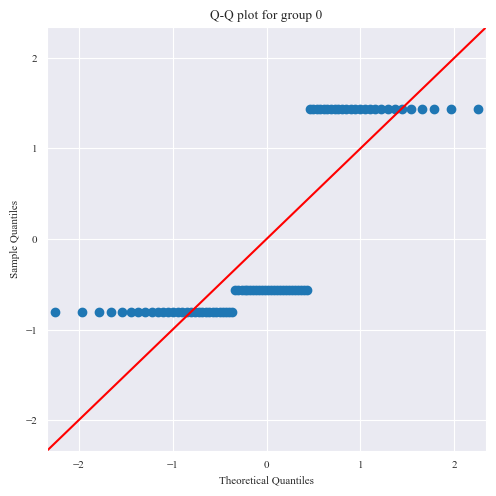

Shapiro test for normality of group 1: W = 0.9612825512886047 and p-value 0.01611301861703396


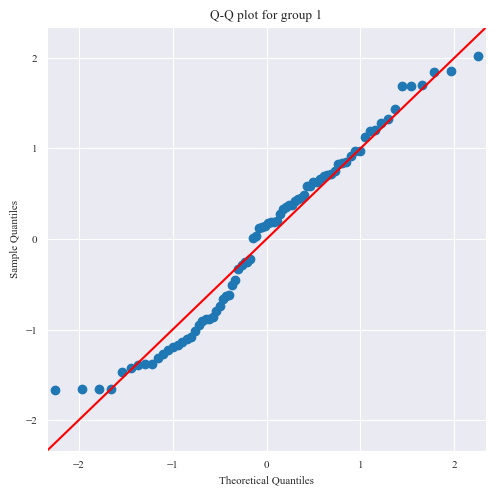

Levene test for equal variances: W = 0.010013064356611121 and p-value = 0.9204193390663635


In [66]:
cloud_df = no_outliers_df.query("`training strategy` == 'cloud'")
test_assumptions(cloud_df["GFLOPs"], cloud_df["energy"])

Shapiro test for normality of group 0: W = 0.636616051197052 and p-value 6.364791332869046e-11


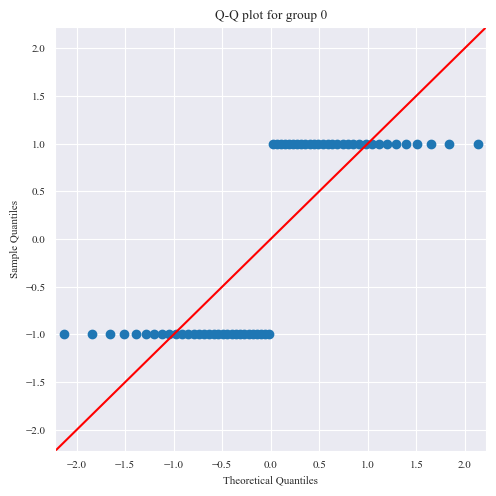

Shapiro test for normality of group 1: W = 0.8400825262069702 and p-value 1.5721900581411319e-06


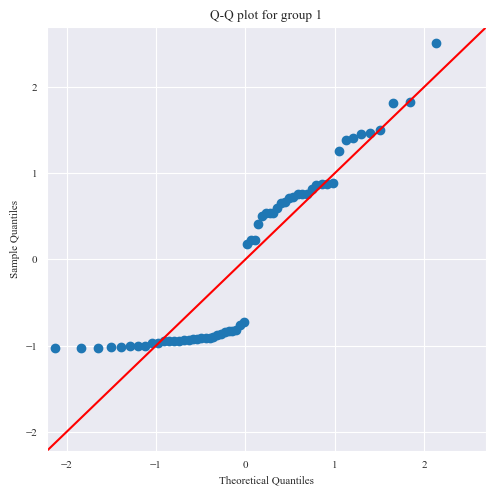

Levene test for equal variances: W = 226.78131680140592 and p-value = 3.0209419868648875e-29


In [67]:
local_df = no_outliers_df.query("`training strategy` == 'local'")
test_assumptions(local_df["GFLOPs"], local_df["energy"])

Energy
          GFLOPs    energy
GFLOPs  1.000000  0.588358
energy  0.588358  1.000000
GPU usage
             GFLOPs  gpu_usage
GFLOPs     1.000000   0.942156
gpu_usage  0.942156   1.000000


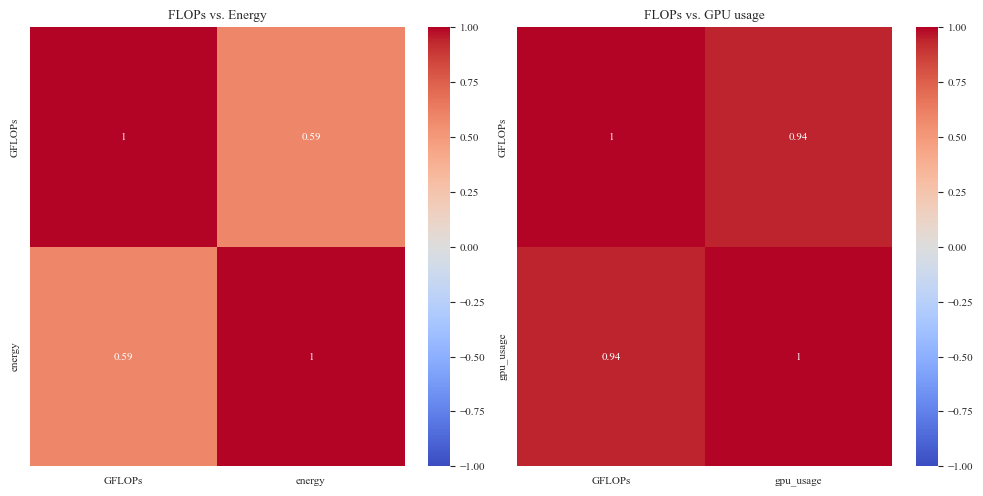

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

data = cloud_df[["GFLOPs", "energy"]]
corr = data.corr("spearman")
print("Energy")
print(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=axes[0], cmap="coolwarm")
ax.set_title(f"FLOPs vs. Energy")

data = cloud_df[["GFLOPs", "gpu_usage"]]
corr = data.corr("spearman")
print("GPU usage")
print(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=axes[1], cmap="coolwarm")
ax.set_title(f"FLOPs vs. GPU usage")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "flops-energy-gpu_usage-correlation.eps"))

## Statistical significance analysis

Remove units from column names to ease working with them.

### RQ1

#### RQ1.1

##### Welch's ANOVA test

In [69]:
rq11_df = pd.concat(
    [cloud_mobilenet, cloud_nasnet_no_temp_outliers, cloud_xception_no_energy_outliers]
)

In [70]:
pg.welch_anova(rq11_df, dv="energy", between="architecture")

,Source,ddof1,ddof2,F,p-unc,np2
0,architecture,2,49.013385,140.376545,5.141740e-21,0.772312


##### Games-Howell post-hoc test

In [71]:
pg.pairwise_gameshowell(rq11_df, dv="energy", between="architecture")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,mobilenet_v2,nasnet_mobile,0.827987,3.306148,-2.478160,0.168135,-14.739069,39.515894,0.000000e+00,-4.031605
1,mobilenet_v2,xception,0.827987,2.411375,-1.583387,0.128195,-12.351421,50.437336,2.764455e-14,-3.292236
2,nasnet_mobile,xception,3.306148,2.411375,0.894773,0.177223,5.048861,43.782617,2.438792e-05,1.379192


##### Kruskal-Wallis test

In [72]:
mobilenet_v2 = rq11_df["energy"][rq11_df["architecture"] == "mobilenet_v2"]
nasnet_mobile = rq11_df["energy"][rq11_df["architecture"] == "nasnet_mobile"]
xception = rq11_df["energy"][rq11_df["architecture"] == "xception"]
stats.kruskal(mobilenet_v2, nasnet_mobile, xception)

KruskalResult(statistic=61.88778227355954, pvalue=3.6411521822108285e-14)

##### Dunn's test

In [73]:
data = [mobilenet_v2, nasnet_mobile, xception]
p_values = sp.posthoc_dunn(data, p_adjust="bonferroni")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,1,2,3
1,False,True,True
2,True,False,True
3,True,True,False


#### RQ1.2

##### One-Way ANOVA test

In [74]:
rq12_df = pd.concat(
    [cloud_mobilenet_no_gpu_outliers, cloud_nasnet_no_gpu_outliers, cloud_xception]
)

In [75]:
model = ols("gpu_usage ~ C(architecture)", data=rq12_df).fit()
aov_table = sm.stats.anova_lm(model, typ=1)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(architecture),2.0,2.00968,1.004840,32944.329703,2.239201e-117
Residual,80.0,0.00244,0.000031,NaN,NaN


##### Tukey post-hoc test

In [76]:
comp = mc.MultiComparison(rq11_df["gpu_usage"], rq11_df["architecture"])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
mobilenet_v2,nasnet_mobile,0.1963,0.0,0.1918,0.2008,True
mobilenet_v2,xception,0.369,0.0,0.3645,0.3735,True
nasnet_mobile,xception,0.1727,0.0,0.168,0.1774,True


##### Kruskal-Wallis test

In [77]:
mobilenet_v2 = rq12_df["gpu_usage"][rq12_df["architecture"] == "mobilenet_v2"]
nasnet_mobile = rq12_df["gpu_usage"][rq12_df["architecture"] == "nasnet_mobile"]
xception = rq12_df["gpu_usage"][rq12_df["architecture"] == "xception"]
result_rq12 = stats.kruskal(mobilenet_v2, nasnet_mobile, xception)
result_rq12

KruskalResult(statistic=72.65834767641996, pvalue=1.6689382565122222e-16)

Eta-squared measure

In [78]:
def eta_squared(H, k, n):
    """
    Compute the eta-squared measure for the Kruskal-Wallis H-test.
    :param H: The value obtained in the Kruskal-Wallis test.
    :param k: The number of groups.
    :param n: The total number of samples.
    :return: The eta-squared estimate.
    """
    return (H - k + 1) / (n - k)


eta_squared(result_rq12[0], 3, rq12_df.shape[0])

0.8832293459552496

##### Dunn's test

In [79]:
data = [mobilenet_v2, nasnet_mobile, xception]
p_values = sp.posthoc_dunn(data, p_adjust="bonferroni")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,1,2,3
1,False,True,True
2,True,False,True
3,True,True,False


In [80]:
print(
    f"Mobilenet V2 - NASNet Mobile effect size: {cliffs_delta(mobilenet_v2, nasnet_mobile)}"
)
print(f"Mobilenet V2 - Xception effect size: {cliffs_delta(mobilenet_v2, xception)}")
print(f"NASNet Mobile - Xception effect size: {cliffs_delta(nasnet_mobile, xception)}")

Mobilenet V2 - NASNet Mobile effect size: (-1.0, 'large')
Mobilenet V2 - Xception effect size: (-1.0, 'large')
NASNet Mobile - Xception effect size: (-1.0, 'large')


#### RQ1.3

In [81]:
rq13_df = pd.concat(
    [
        cloud_mobilenet_no_accuracy_outliers,
        cloud_nasnet_no_accuracy_outliers,
        cloud_xception,
    ]
)

##### One-Way ANOVA test

In [82]:
model = ols("accuracy ~ C(architecture)", data=rq13_df).fit()
aov_table = sm.stats.anova_lm(model, typ=1)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(architecture),2.0,0.011225,0.005613,19.924663,8.283176e-08
Residual,84.0,0.023662,0.000282,NaN,NaN


##### Tukey post-hoc test

In [83]:
comp = mc.MultiComparison(rq13_df["accuracy"], rq13_df["architecture"])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
mobilenet_v2,nasnet_mobile,0.0191,0.0001,0.0085,0.0297,True
mobilenet_v2,xception,0.0272,0.0,0.0167,0.0378,True
nasnet_mobile,xception,0.0081,0.1559,-0.0023,0.0186,False


##### Kruskal-Wallis test

In [84]:
mobilenet_v2 = rq13_df["accuracy"][rq13_df["architecture"] == "mobilenet_v2"]
nasnet_mobile = rq13_df["accuracy"][rq13_df["architecture"] == "nasnet_mobile"]
xception = rq13_df["accuracy"][rq13_df["architecture"] == "xception"]
result_rq13 = stats.kruskal(mobilenet_v2, nasnet_mobile, xception)
result_rq13

KruskalResult(statistic=68.83416068402046, pvalue=1.1294107684781094e-15)

Eta-squared measure

In [85]:
eta_squared(result_rq13[0], 3, rq13_df.shape[0])

0.7956447700478626

##### Dunn's test

In [86]:
data = [mobilenet_v2, nasnet_mobile, xception]
p_values = sp.posthoc_dunn(data, p_adjust="bonferroni")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,1,2,3
1,False,True,True
2,True,False,True
3,True,True,False


In [87]:
print(
    f"Mobilenet V2 - NASNet Mobile effect size: {cliffs_delta(mobilenet_v2, nasnet_mobile)}"
)
print(f"Mobilenet V2 - Xception effect size: {cliffs_delta(mobilenet_v2, xception)}")
print(f"NASNet Mobile - Xception effect size: {cliffs_delta(nasnet_mobile, xception)}")

Mobilenet V2 - NASNet Mobile effect size: (-0.7610837438423645, 'large')
Mobilenet V2 - Xception effect size: (-1.0, 'large')
NASNet Mobile - Xception effect size: (-1.0, 'large')


### RQ2

#### RQ2.1

In [88]:
rq21_df = pd.concat([local_nasnet, cloud_nasnet_no_temp_outliers])

In [89]:
local = rq21_df.energy[rq21_df["training strategy"] == "local"]
cloud = rq21_df.energy[rq21_df["training strategy"] == "cloud"]

##### Independent t-test

In [90]:
stats.ttest_ind(local, cloud)

Ttest_indResult(statistic=16.175674933982243, pvalue=2.3381476758901923e-22)

##### Hedges g

In [91]:
pg.compute_effsize(local, cloud, eftype="hedges")

4.273724513995846

##### Mann-Whitney U test

In [92]:
stats.mannwhitneyu(local, cloud, alternative="two-sided")

MannwhitneyuResult(statistic=780.0, pvalue=1.5637904632766024e-10)

##### Cliff's delta

In [93]:
cliffs_delta(local, cloud)

(1.0, 'large')

#### RQ2.2

In [94]:
rq22_df = pd.concat([local_nasnet, cloud_nasnet_no_gpu_outliers])

In [95]:
local = rq22_df.gpu_usage[rq22_df["training strategy"] == "local"]
cloud = rq22_df.gpu_usage[rq22_df["training strategy"] == "cloud"]

##### Welch's t-test

In [96]:
pg.ttest_ind(local, cloud, equal_var=False)

AttributeError: module 'pingouin' has no attribute 'ttest_ind'

##### Hedges g

In [ ]:
pg.compute_effsize(local, cloud, eftype="hedges")

##### Mann-Whitney U test

In [ ]:
stats.mannwhitneyu(local, cloud, alternative="two-sided")

##### Cliff's delta

In [ ]:
cliffs_delta(local, cloud)
